# 자비스앤빌런즈 "삼쩜삼" 서비스에 대한 고객 Data 분석

## 개요
#### 자비스앤빌런즈 "삼쩜삼" 서비스 주요 정보
  * 개인을 위한 간편 종합소득세 신고 서비스(2020년 런칭)
  * 개인이 간편하게 본인의 예상 환급액을 조회하고 신고하는 절차가 가능한 서비스로, 2021년 8월 현재 기준 누적 가입자수 370만명 수준
  * 관련 정보 참조<br/>
      => 삼쩜삼 웹사이트 : https://www.3o3.co.kr/<br/>
      => 자비스 고객센터 > 삼쩜삼 이용가이드 : https://help.jobis.co/hc/ko/categories/900000038626-%EC%82%BC%EC%A9%9C%EC%82%BC-%EC%9D%B4%EC%9A%A9%EA%B0%80%EC%9D%B4%EB%93%9C

#### 주어진 Data 정보
  * 고객이 각 귀속년도별 근로 / 사업 / 기타 소득에 대한 예상환급액과 수수료를 조회한 뒤, 결제를 하거나 하지 않은 여부를 저장한 Data
  * 총 9개 Column으로 구성<br/>
      => age, gender, year, refund, fee, has_paid, income_근로, income_사업, income_기타

#### 분석 목적
  * 주어진 Data에 기반해 고객의 결제여부에 영향을 미치는 요인을 파악한 뒤,
  * 고객의 수수료 결제금액의 합을 높이기 위한 방안을 마련하기 위함

## 분석 절차 및 주요 내용

### 1. Data 구조 파악 및 Feature별 검토

### 2. 고객의 결제여부에 영향을 미치는 요인 분석
    2-1. 전체 Feature간 상관관계 파악
    2-2. 고객의 결제여부("has_paid")에 따른 특성 비교
    2-3. 결제여부 판단을 위한 "결제비율(%)" 지표 산출 및 그룹별 특성 비교

### 3. 고객의 수수료 결제금액의 합을 높이기 위한 방안 검토

### 4. 결론

---

# 1. Data 구조 파악 및 Feature별 검토

## 1-1. Data 구조 파악

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"]="Malgun Gothic"  # 한글 출력 관련 설정
plt.rcParams["axes.unicode_minus"]=False  # 마이너스("-") 출력 관련 설정

In [2]:
file_path = "./data/Jobis_3o3.csv"
df = pd.read_csv(file_path)
df

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타
0,27.0,F,2019,5000.0,400.0,False,10001000.0,61000.0,NaN
1,34.0,M,2018,100000.0,1700.0,True,18092000.0,NaN,1815000.0
2,28.0,F,2017,289000.0,11500.0,False,NaN,1461000.0,NaN
3,27.0,M,2019,410000.0,16200.0,False,NaN,2471000.0,NaN
4,26.0,F,2016,114000.0,4300.0,True,0.0,689000.0,NaN
...,...,...,...,...,...,...,...,...,...
99995,27.0,F,2019,301000.0,11900.0,True,NaN,NaN,680000.0
99996,62.0,F,2019,77000.0,1300.0,True,NaN,463000.0,NaN
99997,24.0,M,2020,9000.0,400.0,False,7923000.0,54000.0,NaN
99998,24.0,M,2019,34000.0,400.0,True,NaN,204000.0,NaN


In [3]:
df.shape

(100000, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   age        100000 non-null  float64
 1   gender     100000 non-null  object 
 2   year       100000 non-null  int64  
 3   refund     100000 non-null  float64
 4   fee        100000 non-null  float64
 5   has_paid   100000 non-null  bool   
 6   income_근로  40791 non-null   float64
 7   income_사업  78227 non-null   float64
 8   income_기타  25260 non-null   float64
dtypes: bool(1), float64(6), int64(1), object(1)
memory usage: 6.2+ MB


> => "income_근로", "income_사업", "income_기타" Feature에 null값 존재 확인

### income 관련 Feature에 존재하는 null값이 어떤 케이스인지 확인

In [5]:
df.query("income_근로 == 0 or income_사업 == 0 or income_기타 == 0").head(20)

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타
4,26.0,F,2016,114000.0,4300.0,True,0.0,689000.0,NaN
114,25.0,M,2016,282000.0,12300.0,True,0.0,1698000.0,170000.0
215,24.0,F,2017,130000.0,5100.0,False,0.0,784000.0,NaN
327,33.0,F,2016,673000.0,12800.0,True,0.0,5169000.0,NaN
347,24.0,F,2018,123000.0,4700.0,True,0.0,740000.0,NaN
513,24.0,F,2017,28000.0,400.0,True,0.0,170000.0,NaN
653,26.0,M,2017,99000.0,6400.0,True,0.0,599000.0,318000.0
670,21.0,M,2017,5000.0,400.0,True,NaN,0.0,NaN
671,29.0,F,2016,127000.0,3400.0,True,0.0,767000.0,NaN
803,25.0,F,2017,168000.0,6400.0,True,0.0,1014000.0,34000.0


> => income 관련 각 Feature별 '0.0'이 입력된 경우와 'NaN'이 입력된 경우가 혼재함 => 'NaN'이 입력된 내역은 해당 소득이 없거나 또는 누락된 경우로 추정되며, 현재 누락된 금액에 대해서는 파악이 어려우므로 두 가지 케이스 모두 해당 소득금액이 없는 경우로 간주하고 진행하고자 함 => 'NaN'으로 입력된 내역을 '0.0'으로 대체시킨 후 진행

### income 관련 Feature별 존재하는 null값 '0.0'으로 채워주기 => "df_v1"

In [6]:
df_v1 = df.fillna(0.0)
df_v1

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타
0,27.0,F,2019,5000.0,400.0,False,10001000.0,61000.0,0.0
1,34.0,M,2018,100000.0,1700.0,True,18092000.0,0.0,1815000.0
2,28.0,F,2017,289000.0,11500.0,False,0.0,1461000.0,0.0
3,27.0,M,2019,410000.0,16200.0,False,0.0,2471000.0,0.0
4,26.0,F,2016,114000.0,4300.0,True,0.0,689000.0,0.0
...,...,...,...,...,...,...,...,...,...
99995,27.0,F,2019,301000.0,11900.0,True,0.0,0.0,680000.0
99996,62.0,F,2019,77000.0,1300.0,True,0.0,463000.0,0.0
99997,24.0,M,2020,9000.0,400.0,False,7923000.0,54000.0,0.0
99998,24.0,M,2019,34000.0,400.0,True,0.0,204000.0,0.0


## 1-2. 각 Feature별 검토

## &nbsp; 1) age(고객의 만 나이)

In [7]:
df_v1["age"].describe()

count    100000.00000
mean         29.00096
std           7.76819
min          15.00000
25%          24.00000
50%          27.00000
75%          31.00000
max          81.00000
Name: age, dtype: float64

In [8]:
len(df_v1["age"].unique())  # 고유한 나이대 총 개수 확인

65

(array([1.100e+01, 5.400e+01, 2.730e+02, 9.410e+02, 2.312e+03, 3.702e+03,
        5.443e+03, 7.336e+03, 8.713e+03, 9.417e+03, 8.632e+03, 8.126e+03,
        7.209e+03, 6.087e+03, 4.184e+03, 3.583e+03, 3.098e+03, 2.340e+03,
        2.002e+03, 1.767e+03, 1.436e+03, 1.445e+03, 1.195e+03, 1.132e+03,
        1.031e+03, 8.170e+02, 6.970e+02, 6.380e+02, 4.430e+02, 4.530e+02,
        3.980e+02, 4.570e+02, 5.180e+02, 4.550e+02, 4.120e+02, 4.370e+02,
        4.600e+02, 4.210e+02, 3.000e+02, 2.310e+02, 2.830e+02, 2.150e+02,
        2.090e+02, 1.550e+02, 1.280e+02, 9.100e+01, 6.800e+01, 4.000e+01,
        6.800e+01, 2.600e+01, 2.300e+01, 1.700e+01, 1.200e+01, 1.400e+01,
        1.300e+01, 5.000e+00, 4.000e+00, 1.000e+00, 5.000e+00, 0.000e+00,
        7.000e+00, 2.000e+00, 4.000e+00, 1.000e+00, 3.000e+00]),
 array([15.        , 16.01538462, 17.03076923, 18.04615385, 19.06153846,
        20.07692308, 21.09230769, 22.10769231, 23.12307692, 24.13846154,
        25.15384615, 26.16923077, 27.18461538, 28

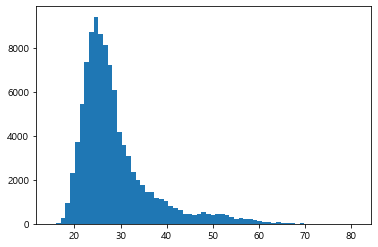

In [9]:
plt.hist(df_v1["age"], bins=65)  # 나이대별 분포 시각화

In [10]:
df_v1["age"].value_counts()  # 나이대별 존재하는 데이터 개수 확인

25.0    9417
24.0    8713
26.0    8632
27.0    8126
23.0    7336
        ... 
81.0       3
77.0       2
79.0       1
73.0       1
15.0       1
Name: age, Length: 65, dtype: int64

### &nbsp;&nbsp; "age" => 평균 29세로 15세~81세의 분포를 보임. 20대 중후반의 데이터가 가장 많은 것을 확인

## &nbsp; 2) gender(고객의 성별)

In [11]:
df_v1["gender"].value_counts()  # 성별에 따른 개수 확인

M    50477
F    49501
-       22
Name: gender, dtype: int64

In [12]:
df_v1[df_v1["gender"] == "-"]  # "gender"가 제대로 입력되지 않은 22개 데이터 내역 확인

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타
2613,27.0,-,2016,559000.0,12800.0,False,0.0,0.0,0.0
4101,27.0,-,2017,209000.0,4300.0,False,0.0,0.0,0.0
9574,42.0,-,2015,175000.0,4300.0,False,0.0,0.0,0.0
20536,26.0,-,2017,845000.0,25100.0,False,0.0,0.0,0.0
28211,26.0,-,2016,650000.0,12800.0,False,0.0,0.0,0.0
36217,27.0,-,2018,124000.0,3400.0,False,0.0,0.0,0.0
37674,27.0,-,2015,252000.0,8500.0,False,0.0,0.0,0.0
38223,53.0,-,2015,6000.0,400.0,False,0.0,0.0,0.0
38441,23.0,-,2018,110000.0,3000.0,False,0.0,0.0,0.0
41454,41.0,-,2015,122000.0,4300.0,True,0.0,0.0,0.0


> => 위 22개 데이터에 대해 성별이 확인되지 않으나, 성별 외 다른 Feature는 구분이 가능하므로 삭제하지 않고 유지하기로 함

### &nbsp;&nbsp; "gender" => 남성이 50.5%, 여성이 49.5% 수준이며, gender 정보가 입력되지 않은 데이터 22개 존재함 확인

## &nbsp; 3) year(소득이 발생한 연도)

In [13]:
df_v1["year"].value_counts()  # 연도별 데이터 개수 확인

2020    23782
2019    20842
2018    19983
2017    17495
2016    13913
2015     3985
Name: year, dtype: int64

<BarContainer object of 6 artists>

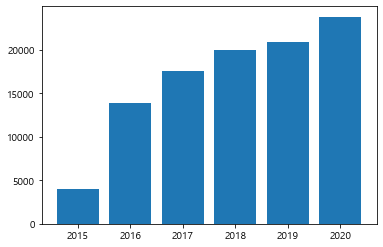

In [14]:
# 연도별 데이터 개수 시각화
x = df_v1["year"].value_counts().sort_values().index
y = df_v1["year"].value_counts().sort_values().values
plt.bar(x, y)

### &nbsp;&nbsp; "year" => 6개년도(2015년~2020년) 데이터가 존재하며, 최근 연도일수록 data수가 증가함을 확인

## &nbsp; 4) refund(예상환급액)

In [15]:
# 과학적표기법 출력 관련, 항상 float 형식으로 출력되도록 설정
pd.set_option("display.float_format", "{:.1f}".format)

In [16]:
df_v1["refund"].describe()

count     100000.0
mean      208142.2
std       307174.4
min     -8265000.0
25%        33000.0
50%        99000.0
75%       254000.0
max      7725000.0
Name: refund, dtype: float64

In [17]:
df_v1["refund"].value_counts().head(20)

5000.0     1998
4000.0     1856
7000.0     1562
6000.0     1233
28000.0    1181
14000.0    1130
11000.0    1084
8000.0     1042
9000.0     1014
10000.0     948
21000.0     889
35000.0     798
13000.0     778
47000.0     773
15000.0     763
25000.0     741
18000.0     730
56000.0     716
38000.0     708
42000.0     686
Name: refund, dtype: int64

### &nbsp;&nbsp; "refund" => 예상환급액 평균은 20.8만원 수준으로 5천원 내외 금액대의 개수가 가장 많음을 확인

## &nbsp; 5) fee(수수료)

In [18]:
df_v1["fee"].describe()

count   100000.0
mean      7247.6
std      11926.9
min        400.0
25%        400.0
50%       4300.0
75%       8500.0
max     307000.0
Name: fee, dtype: float64

In [19]:
# refund 평균 대비 fee 평균 비율 산출 => 약 3.48% 수준
(df_v1["fee"].mean() / df_v1["refund"].mean()) * 100

3.4820615940330035

In [20]:
# refund max값 대비 fee max값 비율 산출 => 약 3.97% 수준
(df_v1["fee"].max() / df_v1["refund"].max()) * 100

3.9741100323624594

### &nbsp;&nbsp; "fee" => refund 금액 수준에 따라 산출되는 금액으로 추정되며, 산출 비율은 약 3.48%(평균금액 기준) 수준임

## &nbsp; 6) has_paid(수수료 결제여부)

In [21]:
df_v1["has_paid"].value_counts()

True     64643
False    35357
Name: has_paid, dtype: int64

### &nbsp;&nbsp; "has_paid" => 수수료 결제 건(True)의 비율이 전체 64.6%로 나타남. 각각의 금액 수준 및 케이스별로 세부 분석 필요

## &nbsp; 7~9) income_근로(근로소득), income_사업(사업소득), income_기타(기타소득)

In [22]:
df_v1[["income_근로", "income_사업", "income_기타"]].describe()  # 각 소득별 data 현황 확인

,income_근로,income_사업,income_기타
count,100000.0,100000.0,100000.0
mean,2623920.6,1182567.1,160725.2
std,5260655.4,2254789.1,795876.1
min,0.0,0.0,0.0
25%,0.0,31000.0,0.0
50%,0.0,328000.0,0.0
75%,2994000.0,1235000.0,2000.0
max,182335000.0,39934000.0,62810000.0


<BarContainer object of 3 artists>

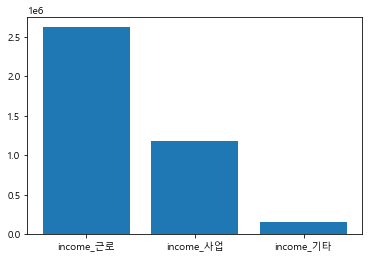

In [23]:
# 각 소득의 평균금액 비교 시각화
x = df_v1[["income_근로", "income_사업", "income_기타"]].columns
y = [df_v1["income_근로"].mean(), df_v1["income_사업"].mean(), df_v1["income_기타"].mean()]
plt.bar(x, y)

### &nbsp;&nbsp; "income_근로, 사업, 기타" => 근로소득 > 사업소득 > 기타소득 순으로 평균금액이 크게 나타나며, 각 소득 내 금액의 분포는 고르지 않음 확인

## 각 Feature별 기본 검토 결과
* 각각의 데이터가 갖는 의미와 분포 현황 등은 확인되었으나 각 Feature간의 연관성에 기반한 추가 파악 필요
* 특히, 결제여부("has_paid")에 따른 그룹별 분류를 통해 각 Feature가 갖는 특징을 디테일하게 분석 필요할 것으로 보임

> ##### [ 검토 과정에서의 의문점 및 추진방안 (1) ]<br/><br/> => 고객 1명에 대해 귀속년도별로 여러개의 데이터가 존재할 수 있을텐데, 현 data상으로는 귀속년도별로 동일고객인지 여부를 특정할 수 있는 Feature(id 등)가 존재하지 않음<br/> => 따라서, 해당 data에 기반하여 귀속년도별 동일고객인지 여부는 고려하지 않고 분석을 진행해야 할 것으로 판단됨

# 2. 고객의 결제여부에 영향을 미치는 요인 분석

## 2-1. 전체 Feature간 상관관계 파악

<ipython-input-24-9de3cb993efe>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))  # 아래쪽 삼각형만 표시되도록 마스크 적용


<AxesSubplot:>

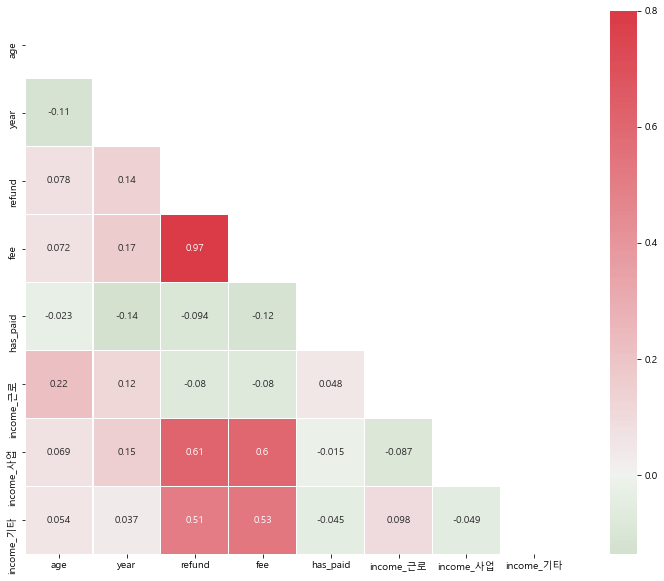

In [24]:
corr = df_v1.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))  # 아래쪽 삼각형만 표시되도록 마스크 적용
plt.figure(figsize=(15,10))
cmap = sns.diverging_palette(120, 10, as_cmap=True)  # 색상 분류기준 설정
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidth=0.5, annot=True, center=0, vmax=0.8)  # 출력값 범위 등 설정값 적용

> => refund와 fee의 상관관계가 매우 높은 것으로 확인됨 => refund 금액에 따라 fee 금액이 결정되기 때문인 것으로 추정 가능

> => 소득 분류 중에서는 사업소득 및 기타소득이 refund 금액과의 상관관계가 높게 나타나며, 근로소득과 refund와의 상관관계는 거의 없는 것으로 확인됨<br/> => (사유 추정) 근로소득에 대해서는 기본적으로 연말정산 시 세금신고 및 처리가 완료되므로 refund 금액에는 특별한 영향을 미치지 않음. 단, 사업소득과 기타소득에 대해서는 해당 고객이 종합소득세 신고기간에 정해진 신고절차 및 처리를 완료하지 않은 경우가 존재할 수 있으며, 그에 따른 해당 사업소득 또는 기타소득에 대한 환급액이 존재하는 것으로 추정 가능

## 2-2. 고객의 결제여부("has_paid")에 따른 특성 비교
### 각 Feature별 시각화 - boxplot, stripplot

In [25]:
# 2개 그래프(boxplot, stripplot) 출력 함수 정의
# 결제여부(has_paid)를 기준으로 두 그룹(True or False)으로 분류하여 각각 비교
def show_plot(feature):
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    sns.boxplot(y=df_v1[feature], x=df_v1["has_paid"])
    plt.ylabel(feature, fontsize=12)
    plt.xlabel("has_paid(결제여부)", fontsize=12)
    plt.subplot(1,2,2)
    sns.stripplot(y=df_v1[feature], x=df_v1["has_paid"])
    plt.ylabel(feature, fontsize=12)
    plt.xlabel("has_paid(결제여부)", fontsize=12)
    plt.show()

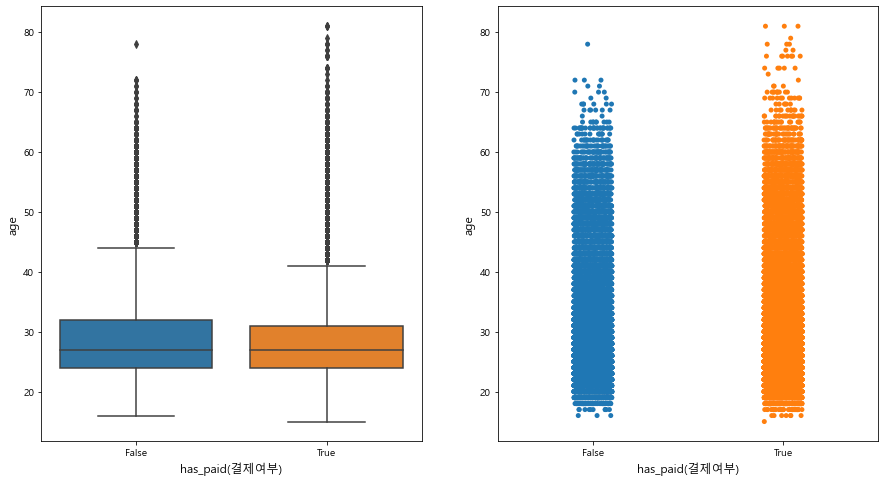

In [26]:
# age 피처의 특성 확인
show_plot("age")

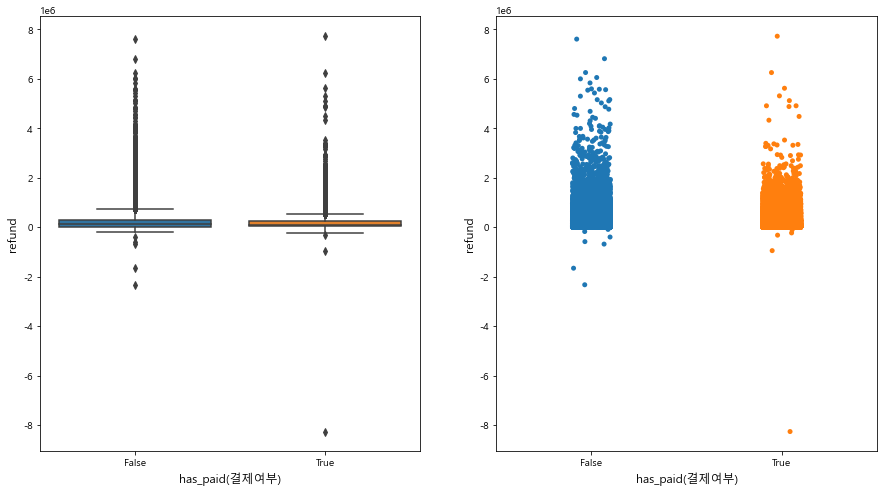

In [27]:
# refund 피처의 특성 확인
show_plot("refund")

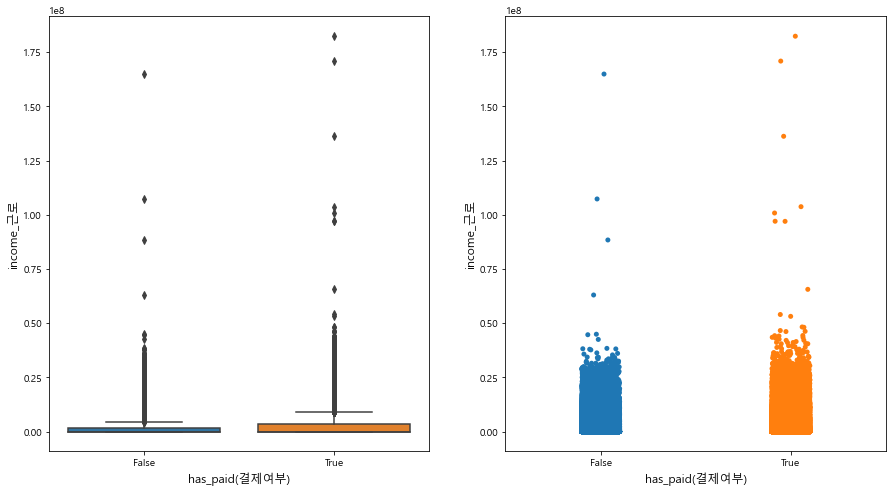

In [28]:
# 근로소득 피처의 특성 확인
show_plot("income_근로")

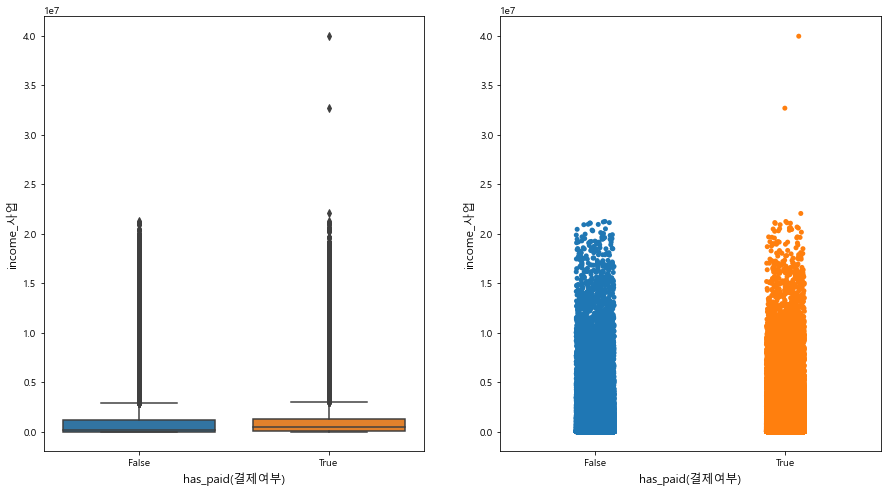

In [29]:
# 사업소득 피처의 특성 확인
show_plot("income_사업")

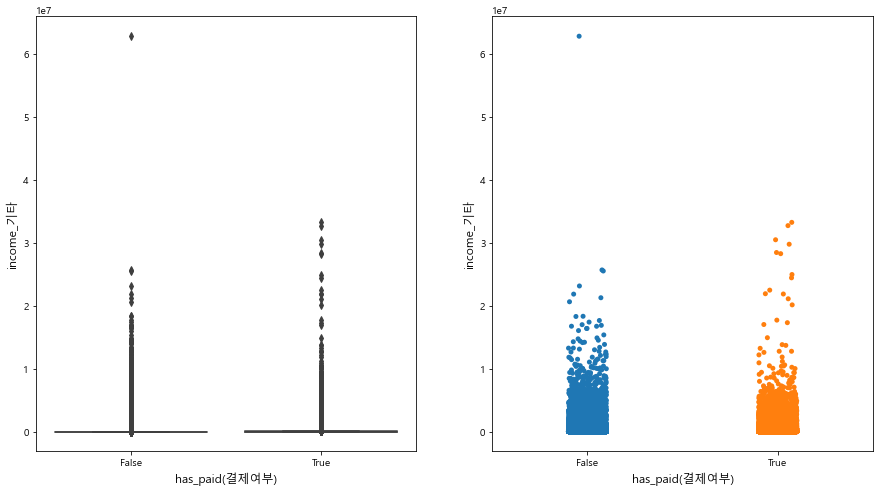

In [30]:
# 기타소득 피처의 특성 확인
show_plot("income_기타")

### &nbsp; => 고객의 결제여부("has_paid")에 따른 그룹별 특성을 시각화해 본 결과,<br/><br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 각 Feature별 일부 차이는 존재하나 유의미한 수준의 큰 차이를 보여주지는 않음

### &nbsp; => 각 Feature간의 관계를 종합해 다각도로 분석이 필요할 것으로 판단됨
<br/><br/>

## 2-3. 결제여부 판단을 위한 "결제비율(%)" 지표 산출 및 그룹별 특성 비교
* 그룹별 결제비율(%)을 산출한 뒤, 각 Feature별 종합적 분석 진행
* 그룹별 결제비율(%) 산출식<br/>
    => "has_paid"값이 True인 개수 / 전체 "has_paid" 개수

## &nbsp; 1) 나이대 그룹별 결제비율 비교

In [31]:
# 각 나이대별 결제비율 산출 함수 정의 - 성별 비교 포함
def get_paid_rate_by_gender(gender):
    # 해당 gender 기준, 나이대별 총 data 개수 산출
    total_count = df_v1[df_v1["gender"] != "-"].groupby(["age", "gender"])["has_paid"].count().unstack()[gender]
    
    # 해당 gender 기준, 나이대별 "has_paid"가 True인 data 개수 산출
    gender_paid = df_v1[df_v1["gender"] != "-"].groupby(["age", "gender", "has_paid"])["has_paid"].count()
    gender_paid = gender_paid.unstack("gender").unstack("has_paid")[(gender, True)]
    
    # 결제비율 계산 => True인 개수 / 총 개수
    paid_rate = (gender_paid / total_count) * 100
    #ret = r.fillna(0)
    
    return paid_rate, total_count

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


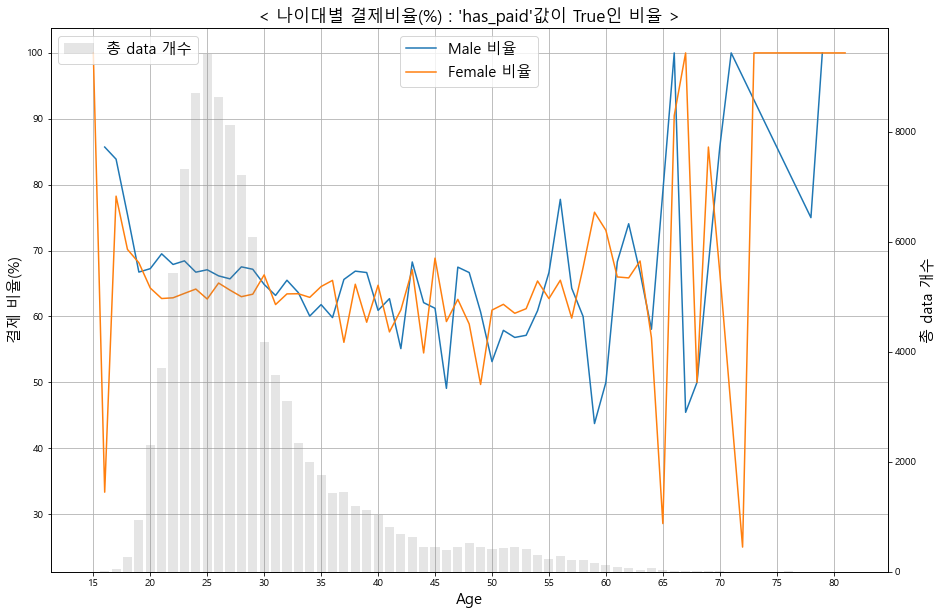

In [32]:
# 나이대별 결제비율 시각화 => 총 data 개수 함께 표기

# 각 성별로 data 저장
m_paid_rate, m_total = get_paid_rate_by_gender("M")
f_paid_rate, f_total = get_paid_rate_by_gender("F")

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # ax1과 x축을 공유하는 ax2 셋팅
fig.set_size_inches(15,10)  # 사이즈 설정

# 각 성별에 따른 나이대별 결제비율 lineplot 출력
sns.lineplot(m_paid_rate.index, m_paid_rate.values, ax=ax1)  # male 그래프
sns.lineplot(f_paid_rate.index, f_paid_rate.values, ax=ax1)  # female 그래프
ax1.grid()  # 격자무늬
plt.xticks(np.arange(15, 82, step=5))  # x축 나이대 표기 설정
ax1.legend(["Male 비율", "Female 비율"], loc="upper center", fontsize=15)
ax1.set_xlabel("Age", fontsize=15)
ax1.set_ylabel("결제 비율(%)", fontsize=15)

# 총 data 개수 bar그래프 출력
total = f_total.fillna(0) + m_total.fillna(0)
ax2.bar(total.index, total.values, color="gray", alpha=0.2)  # 투명도 등 설정
ax2.legend(["총 data 개수"], loc="upper left", fontsize=15)
ax2.set_ylabel("총 data 개수", fontsize=15)

plt.title("< 나이대별 결제비율(%) : 'has_paid'값이 True인 비율 >", fontsize=17)
plt.show()

> => 언뜻 보면, 15세\~19세 또는 50세 이상의 결제비율(%)이 높아보이는 측면이 있으나, 총 data 개수를 살펴보면 해당 나이대의 data 개수 자체가 현저히 적은 것을 알 수 있음<br/> => 따라서, 나이대별 data 개수를 함께 고려한 판단이 필요

> => 일정수준 이상의 data 개수를 나타내는 구간(20세\~40세)을 기준으로 봤을 때, 상대적으로 **20세\~29세의 결제비율이 높은 것**을 알 수 있으며 해당 나이대의 성별 비교 시 **남성의 결제비율이 여성 대비 전반적으로 높은 것**으로 나타남

## &nbsp; 2) Refund 금액수준 그룹별 결제비율 비교
* Refund 금액수준별 그룹핑 후, 각 그룹별 결제비율 추이 비교

### &nbsp; Refund 그룹핑 정보 추가한 신규 데이터프레임 생성 => "df_v1_1"
    => 총 10만개의 data를 refund 금액 기준 내림차순 정렬 후 50개 그룹으로 분류(한 그룹당 2천개 data)

In [33]:
# refund 기준 내림차순 정렬 후, 신규 인덱스 설정
df_v1_1 = df_v1.sort_values(by="refund", ascending=False)
df_v1_1.set_index(np.arange(100000), inplace=True)
df_v1_1

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타
0,25.0,F,2018,7725000.0,307000.0,True,2850000.0,0.0,17297000.0
1,25.0,M,2018,7608000.0,302300.0,False,0.0,0.0,25674000.0
2,40.0,M,2020,6815000.0,270800.0,False,22743000.0,0.0,9779000.0
3,45.0,M,2019,6255000.0,248700.0,False,6776000.0,0.0,14134000.0
4,32.0,F,2017,6254000.0,248300.0,True,0.0,0.0,10918000.0
...,...,...,...,...,...,...,...,...,...
99995,39.0,F,2020,-683000.0,39100.0,False,6082000.0,10649000.0,0.0
99996,48.0,F,2018,-948000.0,3000.0,True,8157000.0,3975000.0,0.0
99997,28.0,F,2020,-1658000.0,1700.0,False,10509000.0,570000.0,0.0
99998,34.0,M,2017,-2328000.0,400.0,False,16759000.0,28000.0,441000.0


In [34]:
# 인덱스 순서에 따라 순차적으로 상위 2천개씩 해당 그룹 정보 입력

df_v1_1["refund_group"] = 0  # 컬럼 생성
group_size = 2000  # 한 그룹당 2천개의 data => 총 50개 그룹
refund_group_list = {}  # 딕셔너리로 그룹핑 정보 별도 저장 => 필요 시 활용

for i in range(int(df_v1_1["refund_group"].count() / group_size)):
    start_i = i * group_size  # 시작 index
    end_i = start_i + group_size  # 종료 index

    df_v1_1.iloc[start_i:end_i]["refund_group"] = i + 1  # 해당 그룹 정보 입력
    refund_group_list[f"{i+1}그룹"] = df_v1_1["refund"].values[start_i:end_i]  # 딕셔너리로 그룹핑 정보 저장

df_v1_1  # 그룹핑 정보 입력 결과 확인

<ipython-input-34-a9059ca3533f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v1_1.iloc[start_i:end_i]["refund_group"] = i + 1  # 해당 그룹 정보 입력


,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타,refund_group
0,25.0,F,2018,7725000.0,307000.0,True,2850000.0,0.0,17297000.0,1
1,25.0,M,2018,7608000.0,302300.0,False,0.0,0.0,25674000.0,1
2,40.0,M,2020,6815000.0,270800.0,False,22743000.0,0.0,9779000.0,1
3,45.0,M,2019,6255000.0,248700.0,False,6776000.0,0.0,14134000.0,1
4,32.0,F,2017,6254000.0,248300.0,True,0.0,0.0,10918000.0,1
...,...,...,...,...,...,...,...,...,...,...
99995,39.0,F,2020,-683000.0,39100.0,False,6082000.0,10649000.0,0.0,50
99996,48.0,F,2018,-948000.0,3000.0,True,8157000.0,3975000.0,0.0,50
99997,28.0,F,2020,-1658000.0,1700.0,False,10509000.0,570000.0,0.0,50
99998,34.0,M,2017,-2328000.0,400.0,False,16759000.0,28000.0,441000.0,50


In [35]:
refund_group_list["1그룹"][:50]  # 1그룹 상위 50개 data 현황 확인

array([7725000., 7608000., 6815000., 6255000., 6254000., 6054000.,
       6000000., 5835000., 5620000., 5595000., 5580000., 5562000.,
       5542000., 5429000., 5312000., 5300000., 5162000., 5158000.,
       5119000., 5109000., 5026000., 4911000., 4910000., 4880000.,
       4871000., 4801000., 4773000., 4686000., 4562000., 4530000.,
       4480000., 4446000., 4403000., 4328000., 4304000., 4192000.,
       4171000., 4105000., 4086000., 4085000., 4046000., 4021000.,
       3996000., 3995000., 3955000., 3953000., 3905000., 3882000.,
       3866000., 3844000.])

### &nbsp; Refund 그룹(1~50그룹)별 결제비율 산출 및 시각화

In [36]:
# 각 refund 그룹별 결제비율 산출 함수 정의
def get_paid_rate_by_refund(gender="total", age=(15, 81)):
    # 성별 미입력 정보 제외 및 나이대 설정값 기준 data 추출
    temp_df = df_v1_1[df_v1_1["gender"] != "-"].query(f"age >= {age[0]} and age <= {age[1]}")

    if gender == "M" or gender == "F":
        # 해당 gender 기준, refund 그룹별 총 data 개수 산출
        gender_count = temp_df.groupby(["refund_group", "gender"])["has_paid"].count().unstack()[gender]

        # 해당 gender 기준, refund 그룹별 "has_paid"가 True인 data 개수 산출
        gender_paid = temp_df.groupby(["refund_group", "gender", "has_paid"])["has_paid"].count()
        gender_paid = gender_paid.unstack("gender").unstack("has_paid")[(gender, True)]
    else:
        # refund 그룹별 총 data 개수 산출
        gender_count = temp_df.groupby("refund_group")["has_paid"].count()
        
        # refund 그룹별 "has_paid"가 True인 data 개수 산출
        gender_paid = temp_df.groupby(["refund_group", "has_paid"])["has_paid"].count()
        gender_paid = gender_paid.unstack("has_paid")[True]
    
    # 결제비율 계산 => True인 개수 / 총 개수
    paid_rate = (gender_paid / gender_count) * 100
    #ret = r.fillna(0)
    
    return paid_rate, gender_count

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


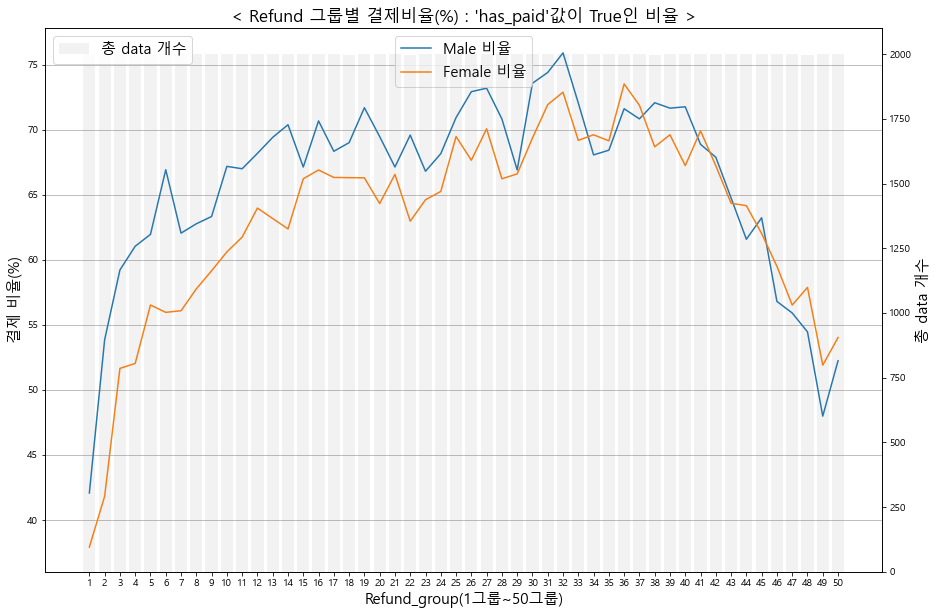

In [37]:
# refund 그룹별 결제비율 시각화 => 총 data 개수 함께 표기

# 각 성별로 data 저장
m_paid_rate, m_total = get_paid_rate_by_refund("M")
f_paid_rate, f_total = get_paid_rate_by_refund("F")

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # ax1과 x축을 공유하는 ax2 셋팅
fig.set_size_inches(15,10)  # 사이즈 설정

# 성별에 따른 refund 그룹별 결제비율 lineplot 출력
sns.lineplot(m_paid_rate.index, m_paid_rate.values, ax=ax1)  # male 그래프
sns.lineplot(f_paid_rate.index, f_paid_rate.values, ax=ax1)  # female 그래프
ax1.grid(axis="y")  # 격자무늬 => 가로방향만 출력
plt.xticks(np.arange(1, 51, step=1))  # x축 그룹번호 표기 설정
ax1.legend(["Male 비율", "Female 비율"], loc="upper center", fontsize=15)
ax1.set_xlabel("Refund_group(1그룹~50그룹)", fontsize=15)
ax1.set_ylabel("결제 비율(%)", fontsize=15)

# 총 data 개수 bar그래프 출력
total = f_total.fillna(0) + m_total.fillna(0)
ax2.bar(total.index, total.values, color="gray", alpha=0.1)  # 투명도 등 설정
ax2.legend(["총 data 개수"], loc="upper left", fontsize=15)
ax2.set_ylabel("총 data 개수", fontsize=15)

plt.title("< Refund 그룹별 결제비율(%) : 'has_paid'값이 True인 비율 >", fontsize=17)
plt.show()

> => 각 그룹별 data 개수는 2천개씩으로 동일한 가운데, 성별에 따른 전체적인 결제비율 추이를 확인 가능

> => Refund 그룹별 추이 확인 결과, **중위그룹(10\~39그룹)의 결제비율이 높게** 나타나며, 특히 30\~39그룹이 가장 높은 것을 알 수 있음

> => Refund 금액이 낮은 하위그룹(40\~50그룹)과 함께 **상위그룹(1\~9그룹)의 결제비율이 상대적으로 낮게** 나타난 점 또한 주목할 필요 있음

### &nbsp; (Refund 그룹 세부검토_1) 30~39그룹의 Refund 금액 현황 확인
    => 평균 47천원 수준이며, 28천원 ~ 71천원의 분포를 보임
    => 해당 그룹 중에서도 가장 결제비율이 높은 32그룹의 Refund 금액 평균은 57천원 수준임

In [38]:
# 30~39그룹의 Refund 금액 현황 확인 => 평균 47,112원
df_v1_1.query("refund_group >= 30 and refund_group <= 39")["refund"].describe()

count   20000.0
mean    47111.9
std     12673.4
min     28000.0
25%     36000.0
50%     46000.0
75%     57000.0
max     71000.0
Name: refund, dtype: float64

In [39]:
# 32그룹(결제 비율 최상위 그룹)의 Refund 금액 현황 확인 => 평균 57,416원
df_v1_1.query("refund_group == 32")["refund"].describe()

count    2000.0
mean    57416.0
std      1460.8
min     55000.0
25%     56000.0
50%     57000.0
75%     59000.0
max     60000.0
Name: refund, dtype: float64

### &nbsp; (Refund 그룹 세부검토_2) 전체 data 결제비율 평균(64.6%)보다 낮아지는 지점(그룹) 확인
    => 상위 그룹에서는 11그룹(64.4%), 하위 그룹에서는 43그룹(64.55%)인 것으로 확인됨

In [40]:
# 아래 그룹번호 입력 후, 해당 그룹의 결제비율(%) 확인 => 11그룹 : 64.4%
check_group = 11
total_count = df_v1_1.query(f"refund_group == {check_group}")["has_paid"].count()
true_count = df_v1_1.query(f"refund_group == {check_group}")["has_paid"].value_counts()[1]
그룹_결제비율 = (true_count / total_count) * 100
print(f"{check_group}그룹의 결제비율 : {그룹_결제비율}%")

11그룹의 결제비율 : 64.4%


In [41]:
# 아래 그룹번호 입력 후, 해당 그룹의 결제비율(%) 확인 => 43그룹 : 64.55%
check_group = 43
total_count = df_v1_1.query(f"refund_group == {check_group}")["has_paid"].count()
true_count = df_v1_1.query(f"refund_group == {check_group}")["has_paid"].value_counts()[1]
그룹_결제비율 = (true_count / total_count) * 100
print(f"{check_group}그룹의 결제비율 : {그룹_결제비율}%")

43그룹의 결제비율 : 64.55%


### &nbsp; (Refund 그룹 세부검토_3) 11그룹의 Refund 및 Fee 금액 분포 현황 확인
    => Refund 금액 평균 : 297,197원
    => Fee 금액 평균 : 10,651원 (Refund 금액 평균 * 3.58%)

In [42]:
df_v1_1.query("refund_group == 11")["refund"].describe()  # 11그룹 Refund 금액 분포 확인

count     2000.0
mean    297197.0
std       7958.4
min     284000.0
25%     290000.0
50%     296000.0
75%     304000.0
max     312000.0
Name: refund, dtype: float64

In [43]:
df_v1_1.query("refund_group == 11")["fee"].describe()  # 11그룹 Fee 금액 분포 확인

count    2000.0
mean    10650.5
std      1868.2
min      8100.0
25%      8500.0
50%     11500.0
75%     11900.0
max     49300.0
Name: fee, dtype: float64

In [44]:
# 11그룹의 Refund 평균 대비 Fee 평균 계산
r = df_v1_1.query("refund_group == 11")["fee"].mean() / df_v1_1.query("refund_group == 11")["refund"].mean()
r * 100

3.583649902253387

### &nbsp; (Refund 그룹 세부검토_4) 43그룹의 Refund 및 Fee 금액 분포 현황 확인
    => Refund 금액 평균 : 16,624원
    => Fee 금액 평균 : 511원 (Refund 금액 평균 * 3.07%)

In [45]:
df_v1_1.query("refund_group == 43")["refund"].describe()  # 43그룹 Refund 금액 분포 확인

count    2000.0
mean    16623.5
std       961.4
min     15000.0
25%     16000.0
50%     17000.0
75%     17000.0
max     18000.0
Name: refund, dtype: float64

In [46]:
df_v1_1.query("refund_group == 43")["fee"].describe()  # 43그룹 Fee 금액 분포 확인

count    2000.0
mean      510.6
std      1705.0
min       400.0
25%       400.0
50%       400.0
75%       400.0
max     54000.0
Name: fee, dtype: float64

In [47]:
# 43그룹의 Refund 평균 대비 Fee 평균 계산
r = df_v1_1.query("refund_group == 43")["fee"].mean() / df_v1_1.query("refund_group == 43")["refund"].mean()
r * 100

3.0712545492826417

## Refund 금액수준 그룹별 결제비율 분석 결과
* 중위그룹의 결제비율이 하위그룹은 물론이고, 상위그룹의 결제비율보다도 높다는 특징이 있음
* 전체 data상 결제비율의 평균인 64.6%보다 낮아지는 지점(그룹)의 특징 분석
  - 해당 지점(그룹) => 상위그룹 : 11그룹 / 하위그룹 : 43그룹
  - 하위그룹(43그룹)의 경우, Refund 금액이 2만원 근접한 수준에서 1만원대 중반으로 내려오는 지점으로 확인됨
  - 상위그룹(11그룹)의 경우, Fee 금액이 1만원대로 최초 진입하는 지점으로 확인됨

> 하위그룹(43그룹 이하)은 환급 받게 되는 금액이 생각보다 크지 않은 것을 확인 후, 최종 결제하지 않은 것으로 추정<br/>
> 상위그룹(11그룹 이상)은 지불해야 할 수수료 금액이 생각보다 큰 것을 확인 후, 최종 결제하지 않은 것으로 추정

    => 기본적으로 환급 받게 되는 금액이 커질수록 수수료 금액도 연동되어 커지게 되는데, 상위 그룹의 경우 해당 수수료 지불 의사에 대한 허들금액이 존재하는 것으로 판단되며, 위 분석결과에 따라 해당 수수료 허들금액은 평균 1만원 수준인 것으로 파악됨 => 이후 좀 더 세부적인 분석 진행 예정
    

> ##### [ 검토 과정에서의 의문점 및 추진방안 (2) ] - 세부내역 아래 참조<br/><br/> => 고객의 결제여부(has_paid)가 True인 건 중에 예상환급액(refund) 대비 수수료(fee)가 큰 순서로 정렬해 살펴봤을 때, 예상환급액보다 수수료가 오히려 더 큰 건들이 49건 존재함<br/><br/> => 해당 건 기준으로만 보면 납득하기 어려우나, 해당 고객 입장에서 만약 다른 귀속년도의 data가 함께 있었을 경우 연도별 예상환급액 총합이 수수료 총합보다 큰 경우였다면 납득이 가능하다고 판단됨<br/><br/> => 다만, 현 data 기준상으로는 각각의 data가 동일고객의 data인지를 특정할 수 있는 정보가 없기 때문에 고객 단위로 정보를 분석하기에는 한계가 있음<br/><br/> => 따라서, 분석 과정에서 몇몇 개별 data가 나타내는 특이한 부분보다는 (위에서 진행한 방식과 같은) 적절한 단위의 그룹핑을 통해 그룹화된 data가 나타내는 특성과 추이에 포인트를 맞춰야 할 것으로 판단됨

##### [ 검토 과정에서의 의문점 ] 관련 세부내역

In [48]:
# refund에 대한 fee의 산출율 정보("fee_ratio") Column 추가한 데이터프레임 생성 => "df_V2"
df_v2 = df_v1_1
df_v2["fee_ratio"] = (df_v2["fee"] / df_v2["refund"]) * 100
df_v2

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타,refund_group,fee_ratio
0,25.0,F,2018,7725000.0,307000.0,True,2850000.0,0.0,17297000.0,1,4.0
1,25.0,M,2018,7608000.0,302300.0,False,0.0,0.0,25674000.0,1,4.0
2,40.0,M,2020,6815000.0,270800.0,False,22743000.0,0.0,9779000.0,1,4.0
3,45.0,M,2019,6255000.0,248700.0,False,6776000.0,0.0,14134000.0,1,4.0
4,32.0,F,2017,6254000.0,248300.0,True,0.0,0.0,10918000.0,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,39.0,F,2020,-683000.0,39100.0,False,6082000.0,10649000.0,0.0,50,-5.7
99996,48.0,F,2018,-948000.0,3000.0,True,8157000.0,3975000.0,0.0,50,-0.3
99997,28.0,F,2020,-1658000.0,1700.0,False,10509000.0,570000.0,0.0,50,-0.1
99998,34.0,M,2017,-2328000.0,400.0,False,16759000.0,28000.0,441000.0,50,-0.0


In [49]:
# 고객의 결제여부(has_paid)가 True인 건 중에 fee_ratio가 높은 순서로 정렬 => fee_ratio가 100% 이상인 데이터들이 존재함(49개)
df_v2.query("has_paid == True").sort_values(by="fee_ratio", ascending=False).iloc[:50]

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타,refund_group,fee_ratio
99930,48.0,F,2019,0.0,400.0,True,6803000.0,179000.0,0.0,50,inf
99926,25.0,F,2016,0.0,400.0,True,8534000.0,80000.0,0.0,50,inf
99971,43.0,F,2019,0.0,8500.0,True,11833000.0,1942000.0,647000.0,50,inf
99964,28.0,F,2016,0.0,400.0,True,0.0,77000.0,0.0,50,inf
99954,39.0,F,2019,0.0,400.0,True,13786000.0,35000.0,0.0,50,inf
99953,26.0,F,2019,0.0,4300.0,True,5254000.0,969000.0,0.0,50,inf
99947,30.0,F,2016,0.0,400.0,True,13614000.0,213000.0,0.0,50,inf
99946,29.0,F,2017,0.0,400.0,True,9124000.0,38000.0,0.0,50,inf
99944,33.0,F,2016,0.0,400.0,True,8496000.0,102000.0,0.0,50,inf
99924,36.0,M,2018,0.0,400.0,True,3614000.0,1000.0,74000.0,50,inf


## &nbsp; 3) 결제비율 기반, Refund 금액수준별 2차 그룹핑 및 주요 Feature에 대한 특성 비교
* 위에서 분류한 Refund 그룹(1~50그룹)을 활용해 결제비율을 기반으로 아래와 같이 4개 그룹으로 분류
* 4개 그룹 분류 기준(아래 그래프 참조)
  - A그룹(Refund 1 ~ 11그룹) : 결제비율이 전체 평균(64.6%) 이하인 Refund 상위 그룹
  - B그룹(Refund 12 ~ 24그룹) : 결제비율이 전체 평균(64.6%) 이상 & 70% 이하인 Refund 중위 그룹
  - C그룹(Refund 25 ~ 42그룹) : 결제비율이 전체 평균(64.6%) 이상 & 70% 이상인 Refund 중위 그룹
  - D그룹(Refund 43 ~ 50그룹) : 결제비율이 전체 평균(64.6%) 이하인 Refund 하위 그룹

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


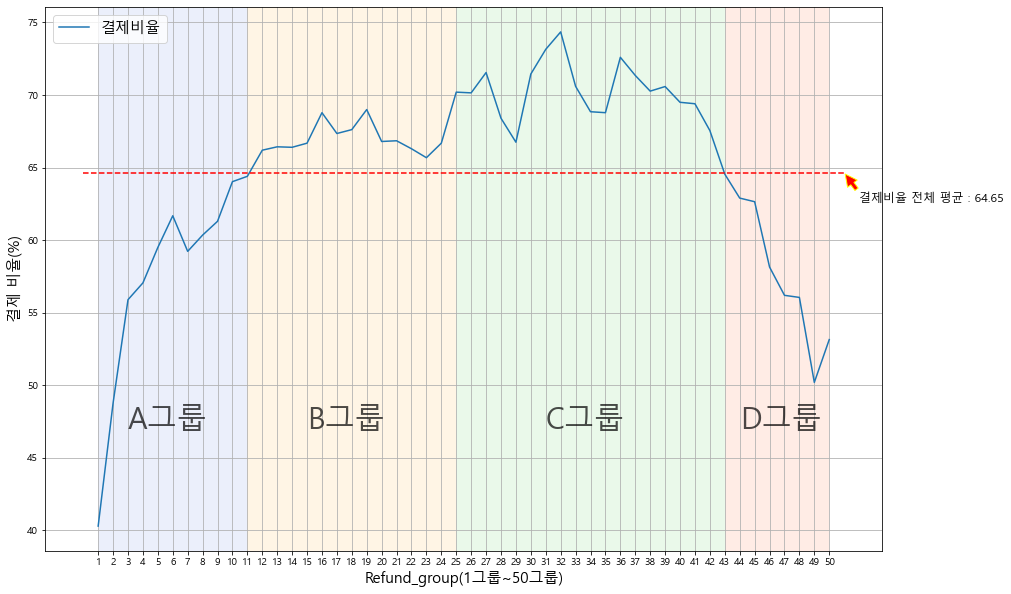

In [50]:
# 4개 그룹 분류 기준 시각화

total_paid_rate, total_count = get_paid_rate_by_refund()

plt.figure(figsize=(15,10))
sns.lineplot(total_paid_rate.index, total_paid_rate.values)
plt.plot([0, 51], [total_paid_rate.mean(), total_paid_rate.mean()], "r--")  # 결제비율 전체 평균(64.6%) 값을 점선으로 표시
plt.grid()  # 격자무늬
plt.xticks(np.arange(1, 51, step=1))  # x축 그룹번호 표기 설정
plt.legend(["결제비율"], loc="upper left", fontsize=15)
plt.xlabel("Refund_group(1그룹~50그룹)", fontsize=15)
plt.ylabel("결제 비율(%)", fontsize=15)

# "결제비율 전체 평균" 주석 삽입
plt.annotate("결제비율 전체 평균 : %.2f"%(total_paid_rate.mean()), fontsize=12,
            xy=(51, total_paid_rate.mean()),  # 주석의 해당 위치
            xytext=(51 + 1, total_paid_rate.mean() - 2),  # 주석에 대한 텍스트 위치
            arrowprops=dict(facecolor="red", edgecolor="yellow", shrink=0.07))  # 화살표 속성 설정

# 그룹별 구간 강조 색상 표시
plt.axvspan(1, 11, facecolor='royalblue', alpha=0.1)
plt.axvspan(11, 25, facecolor='orange', alpha=0.1)
plt.axvspan(25, 43, facecolor='limegreen', alpha=0.1)
plt.axvspan(43, 50, facecolor='orangered', alpha=0.1)

# 구간별 그룹명 표기
plt.annotate("A그룹", xy=(3, 47), xytext=(3, 47), fontsize=30, alpha=0.7)
plt.annotate("B그룹", xy=(15, 47), xytext=(15, 47), fontsize=30, alpha=0.7)
plt.annotate("C그룹", xy=(31, 47), xytext=(31, 47), fontsize=30, alpha=0.7)
plt.annotate("D그룹", xy=(44, 47), xytext=(44, 47), fontsize=30, alpha=0.7)

plt.show()

### &nbsp; 4개 그룹 정보 입력한 데이터프레임 생성 => "df_v3"

In [51]:
# 4개 그룹 정보 입력을 위한 "refund_group_2" Column 생성
df_v3 = df_v2
df_v3["refund_group_2"] = "그룹명"

# 각 그룹명 정보 입력
df_v3.iloc[0:11*2000]["refund_group_2"] = "A그룹"
df_v3.iloc[11*2000:24*2000]["refund_group_2"] = "B그룹"
df_v3.iloc[24*2000:42*2000]["refund_group_2"] = "C그룹"
df_v3.iloc[42*2000:]["refund_group_2"] = "D그룹"

df_v3  # 결과 확인

<ipython-input-51-27ecf8b8f88d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v3.iloc[0:11*2000]["refund_group_2"] = "A그룹"
<ipython-input-51-27ecf8b8f88d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v3.iloc[11*2000:24*2000]["refund_group_2"] = "B그룹"
<ipython-input-51-27ecf8b8f88d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타,refund_group,fee_ratio,refund_group_2
0,25.0,F,2018,7725000.0,307000.0,True,2850000.0,0.0,17297000.0,1,4.0,A그룹
1,25.0,M,2018,7608000.0,302300.0,False,0.0,0.0,25674000.0,1,4.0,A그룹
2,40.0,M,2020,6815000.0,270800.0,False,22743000.0,0.0,9779000.0,1,4.0,A그룹
3,45.0,M,2019,6255000.0,248700.0,False,6776000.0,0.0,14134000.0,1,4.0,A그룹
4,32.0,F,2017,6254000.0,248300.0,True,0.0,0.0,10918000.0,1,4.0,A그룹
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,39.0,F,2020,-683000.0,39100.0,False,6082000.0,10649000.0,0.0,50,-5.7,D그룹
99996,48.0,F,2018,-948000.0,3000.0,True,8157000.0,3975000.0,0.0,50,-0.3,D그룹
99997,28.0,F,2020,-1658000.0,1700.0,False,10509000.0,570000.0,0.0,50,-0.1,D그룹
99998,34.0,M,2017,-2328000.0,400.0,False,16759000.0,28000.0,441000.0,50,-0.0,D그룹


In [52]:
# 4개 그룹명 입력 결과 검증 작업 진행

name_list = ["A그룹", "B그룹", "C그룹", "D그룹"]

for name in name_list[:]:
    print(name, ":", df_v3[df_v3["refund_group_2"] == name]["refund_group"].unique())  # A~D그룹별 refund_group 내역 정보 확인

A그룹 : [ 1  2  3  4  5  6  7  8  9 10 11]
B그룹 : [12 13 14 15 16 17 18 19 20 21 22 23 24]
C그룹 : [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
D그룹 : [43 44 45 46 47 48 49 50]


### &nbsp; 4개 그룹별 주요 Feature에 대한 특성 비교

In [53]:
# 각 Feature별로 4개 그룹의 그래프 출력 함수 정의
def show_graph_by_group(feature, group="all", age=(15, 81), size_set=(15,8)):
    temp_df = df_v3.query(f"age >= {age[0]} and age <= {age[1]}")
    
    if group == "A&D제외":
        plt.figure(figsize=size_set)
        plt.subplot(1,2,1)
        temp_df = temp_df.query("refund_group_2 != 'A그룹' and refund_group_2 != 'D그룹'")
        sns.boxplot(y=temp_df[feature], x=temp_df["refund_group_2"])
        plt.ylabel(feature, fontsize=12)
        plt.xlabel("그룹명", fontsize=12)
        plt.subplot(1,2,2)
        sns.stripplot(y=temp_df[feature], x=temp_df["refund_group_2"])
        plt.ylabel(feature, fontsize=12)
        plt.xlabel("그룹명", fontsize=12)
    else:
        plt.figure(figsize=size_set)
        plt.subplot(1,2,1)
        sns.boxplot(y=temp_df[feature], x=temp_df["refund_group_2"])
        plt.ylabel(feature, fontsize=12)
        plt.xlabel("그룹명", fontsize=12)
        plt.subplot(1,2,2)
        sns.stripplot(y=temp_df[feature], x=temp_df["refund_group_2"])
        plt.ylabel(feature, fontsize=12)
        plt.xlabel("그룹명", fontsize=12)
    
    plt.show()

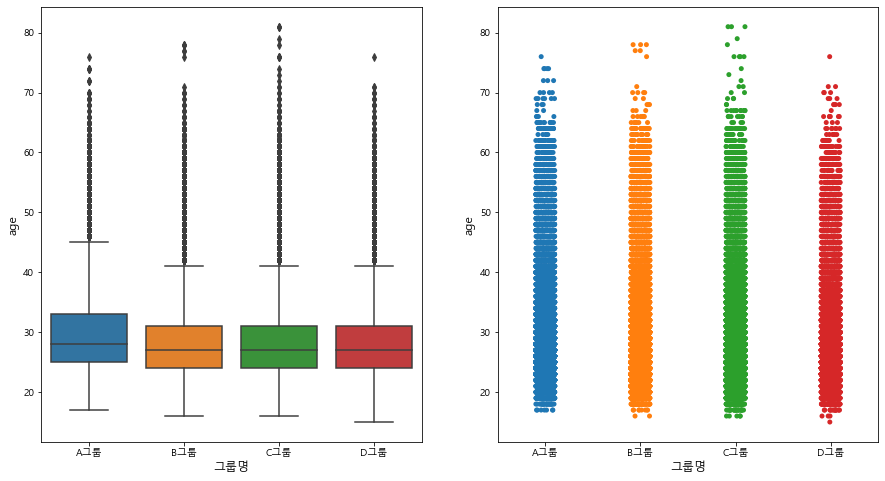

In [54]:
# age 피처의 현황 확인
show_graph_by_group("age")

> => 평균나이 기준 A그룹이 가장 높게 나타나며, 나머지 3개 그룹은 거의 차이가 없는 수준임

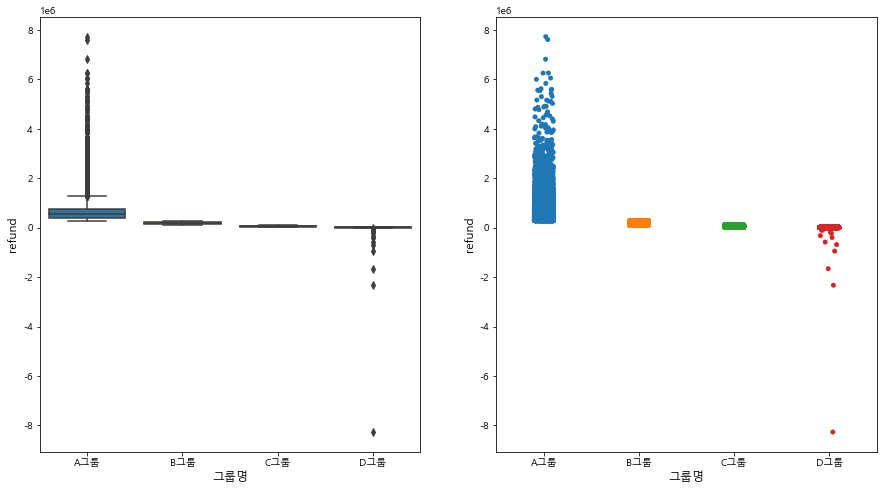

In [55]:
# refund 피처의 현황 확인
show_graph_by_group("refund")

> => 기본적으로 refund 금액수준에 따라 그룹을 분류했으므로, A그룹 > B그룹 > C그룹 > D그룹 순서로 refund 금액이 큰 것은 당연하나 A그룹의 refund 금액 크기가 다른 그룹에 비해 비교되지 않을 정도로 큰 것을 확인할 수 있음

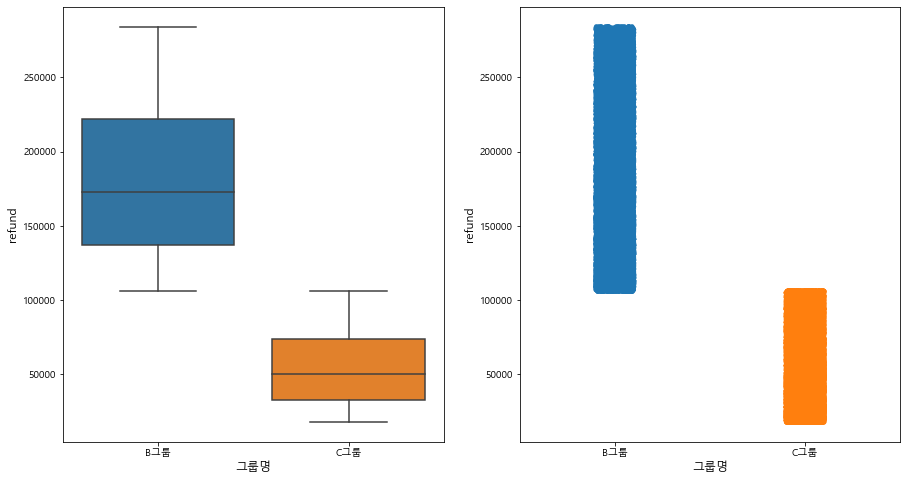

In [56]:
# refund 피처의 현황 확인 => B와 C그룹만 비교
show_graph_by_group("refund", "A&D제외")

> => B와 C그룹의 차이를 확인해보기 위해 단독 비교를 진행함<br/> => B그룹은 17만원 내외 수준, C그룹은 5만원 내외 수준인 것으로 확인됨

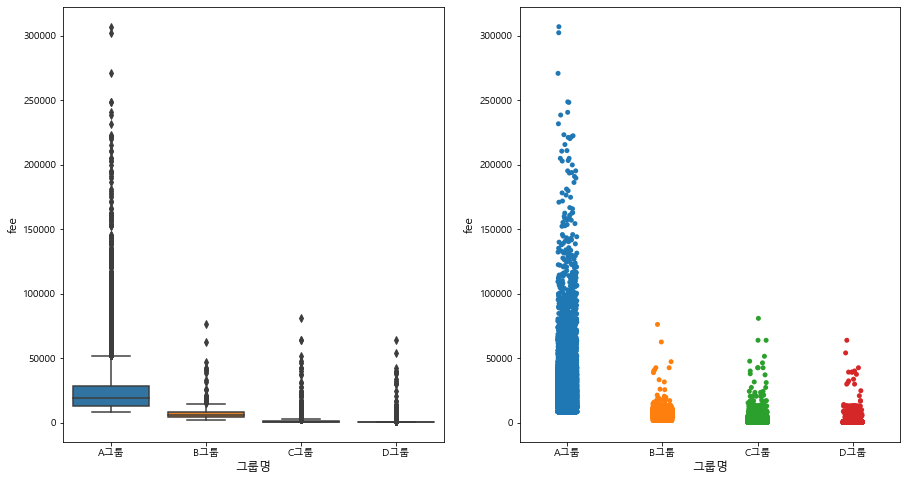

In [57]:
# fee 피처의 현황 확인
show_graph_by_group("fee")

> => refund 금액과 연동되는 특성이 재차 확인되며, refund 금액과 마찬가지로 A그룹의 fee 금액이 타그룹 대비 훨씬 큰 것으로 나타남

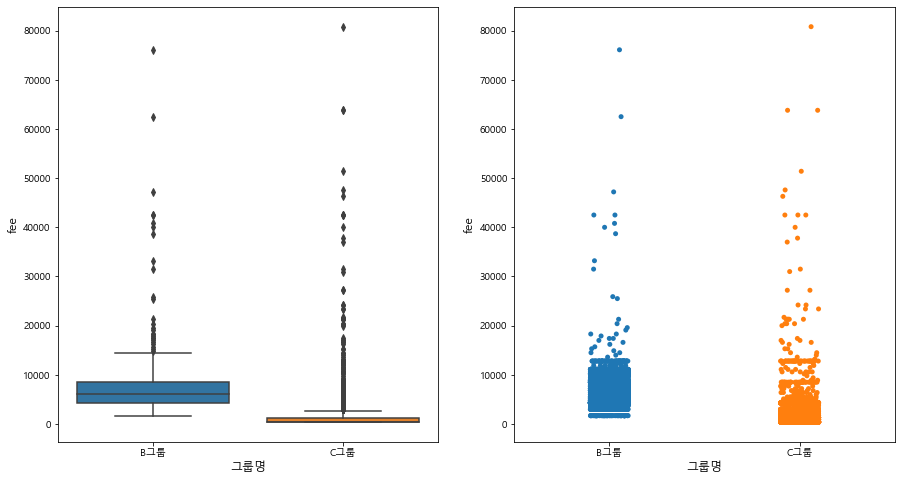

In [58]:
# fee 피처의 현황 확인 => B와 C그룹만 비교
show_graph_by_group("fee", "A&D제외")

> => B와 C그룹 단독 비교 시 B그룹 금액이 확실히 높게 나타나는 가운데, 우측 그래프상 각 그룹별 특정 금액대가 비어있거나 data가 몰려있는 현상이 관찰됨

In [59]:
# B그룹, C그룹의 수수료(fee) 금액별 분포 확인
df_v3.query("refund_group_2 == 'B그룹' or refund_group_2 == 'C그룹'")["fee"].value_counts().head(10)

400.0     18138
4300.0    10067
900.0      5880
1300.0     4392
1700.0     3539
8500.0     2854
4700.0     1451
5500.0     1401
6400.0     1292
5100.0     1273
Name: fee, dtype: int64

In [60]:
# B그룹, C그룹의 수수료(fee) 관련 고유한 금액 리스트 확인
np.sort(df_v3.query("refund_group_2 == 'B그룹' or refund_group_2 == 'C그룹'")["fee"].unique())

array([  400.,   900.,  1300.,  1700.,  2100.,  2600.,  3000.,  3400.,
        3800.,  4300.,  4700.,  5100.,  5500.,  6000.,  6400.,  6800.,
        7200.,  7700.,  8100.,  8500.,  8900.,  9400.,  9800., 10200.,
       10600., 11100., 11500., 11900., 12300., 12800., 13200., 13600.,
       14000., 14500., 14900., 15300., 15700., 16200., 16600., 17000.,
       17400., 17900., 18300., 19100., 19600., 20000., 20400., 21300.,
       21700., 23400., 24200., 25500., 25900., 27200., 31000., 31500.,
       33200., 37000., 37800., 38700., 40000., 40800., 42500., 46300.,
       47200., 47600., 51400., 62500., 63800., 76100., 80800.])

> => 수수료(fee) 금액이 최소 400원부터 400~500원 단위로 증가하는 구조로 파악되며, data 분포상 400원과 4300원에 특히 많은 data가 몰려있는 것이 확인됨

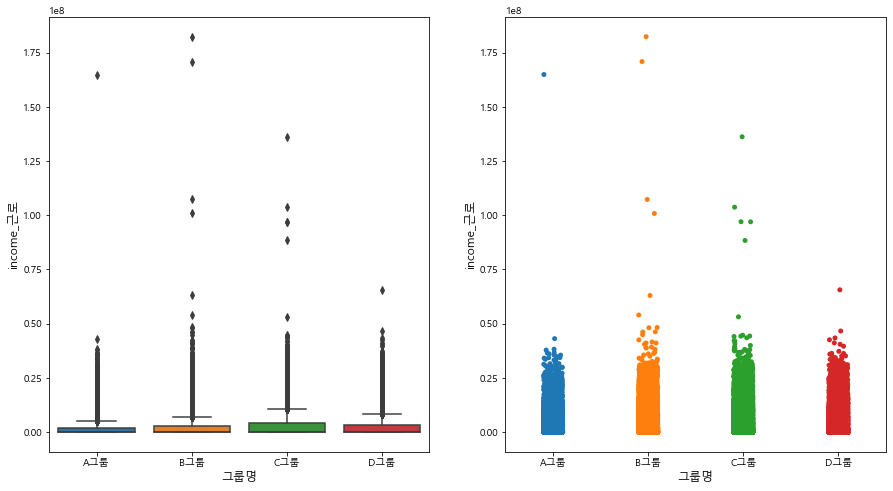

In [61]:
# income_근로 피처의 현황 확인
show_graph_by_group("income_근로")

> => 앞서 Feature별 상관분석에서 확인된대로 refund 금액과의 상관관계가 낮은 근로소득에 대해서는 그룹별 전반적으로 비슷한 수준을 보이고 있으며, 큰 차이는 없으나 상대적으로 C그룹의 근로소득 수준이 가장 높은 것을 알 수 있음

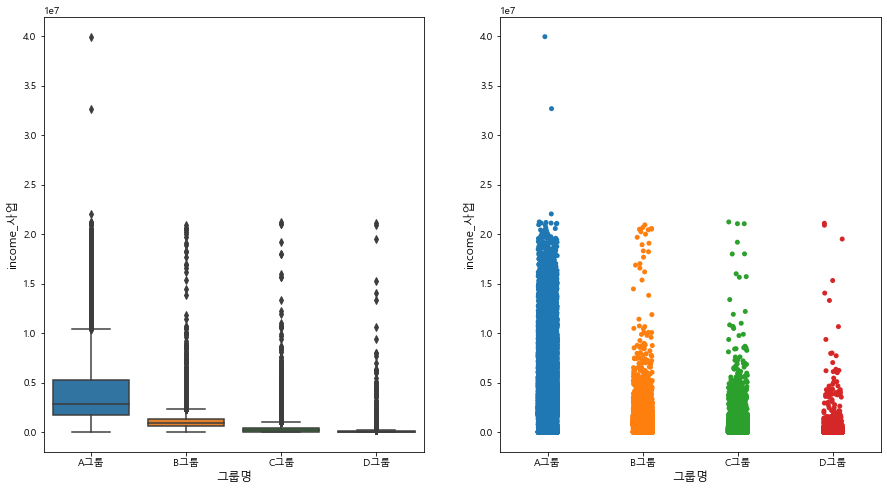

In [62]:
# income_사업 피처의 현황 확인
show_graph_by_group("income_사업")

> => refund 금액과 상관관계가 높은 사업소득은 A그룹이 확실하게 높은 가운데, B그룹과 C그룹간의 차이도 확인됨

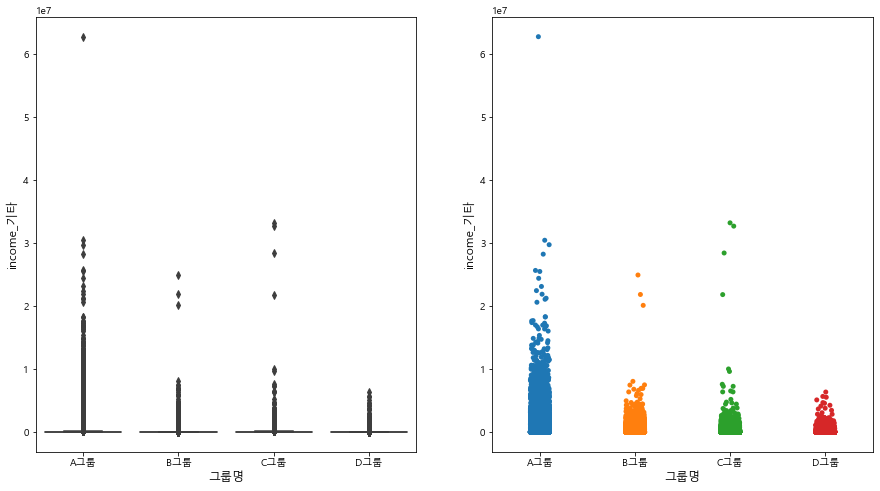

In [63]:
# income_기타 피처의 현황 확인
show_graph_by_group("income_기타")

> => 기타소득은 평균적으로 크게 차이가 나지 않는 가운데, A그룹이 상대적으로 조금 더 높은 것을 확인함

## 고객의 결제여부에 영향을 미치는 요인 분석 결과
* 각 Feature별 단순 비교 검토 시에는 의미있는 결론에 이르지 못함
* 주요 Feature별 적절한 그룹핑 후 각 그룹의 결제여부 수준을 판단할 수 있는 **"결제비율" 지표를 산출해 그룹별 추이를 비교/분석**함으로써, 고객의 결제여부 수준("결제비율" 값의 크기)에 대해 그룹별 유의미한 차이를 보이는 요인 2가지를 확인할 수 있었음
### => 고객의 결제여부에 영향을 미치는 요인 : 나이, 예상환급액

    ※ 수수료는 예상환급액과 상관관계가 매우 높음(0.97)에 따라 별도 요인으로 구분하지 않음
<br/>

# 3. 고객의 수수료 결제금액의 합을 높이기 위한 방안 검토
* 지금까지의 분석 과정을 종합적으로 적용해 '나이'와 '예상환급액'에 따른 결제비율 특성을 세부적으로 비교/분석
* 수수료 결제금액의 총합은 "평균 결제금액 x 총 결제건수"로 정의하고, 아래 2가지 차원에서 검토를 진행<br/>
  1) 고객별 수수료 결제금액의 평균을 높이는 방안<br/>
  2) 고객 전체의 수수료 결제건수를 높이는 방안

### &nbsp; '나이'와 '예상환급액' 그룹별 특성을 종합적으로 분석하기 위한 시각화 함수 정의

In [64]:
# 나이에 따라 추출된 data 기준, refund 그룹별 결제비율 시각화 함수 정의 => 총 data 개수 bar 함께 표기 

def show_paid_rate_by_group_with_count(gender="each", age_range=(15, 81), grouping=1):  # 옵션별 초기 설정값 셋팅

    # data 저장
    m_paid_rate, m_total = get_paid_rate_by_refund("M", age=(age_range[0], age_range[1]))  # 옵션 설정값 반영
    f_paid_rate, f_total = get_paid_rate_by_refund("F", age=(age_range[0], age_range[1]))  # 옵션 설정값 반영
    total_paid_rate, total_count = get_paid_rate_by_refund(age=(age_range[0], age_range[1]))  # 옵션 설정값 반영

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()  # ax1과 x축을 공유하는 ax2 셋팅
    fig.set_size_inches(14,10)  # 사이즈 설정

    # 성별에 따른 결제비율 lineplot 출력
    sns.lineplot(m_paid_rate.index, m_paid_rate.values, ax=ax1)  # male 그래프
    sns.lineplot(f_paid_rate.index, f_paid_rate.values, ax=ax1)  # female 그래프
    if gender == "total":
        sns.lineplot(total_paid_rate.index, total_paid_rate.values, linestyle="dotted", alpha=0.5, ax=ax1)  # total 그래프
    ax1.grid(axis="y")  # 격자무늬 => 가로방향만 출력
    plt.xticks(np.arange(1, 51, step=1))  # x축 그룹번호 표기 설정
    if gender != "total":
        ax1.legend(["Male 비율", "Female 비율"], loc="upper right", fontsize=15)
    else:
        ax1.legend(["Male 비율", "Female 비율", "Total 비율"], loc="upper right", fontsize=15)
    ax1.set_xlabel("Refund_group(1그룹~50그룹)", fontsize=15)
    ax1.set_ylabel("결제 비율(%)", fontsize=15)

    ax1.plot([0, 51], [total_paid_rate.mean(), total_paid_rate.mean()], "r--")  # 결제비율 전체 평균 값을 점선으로 표시

    # "결제비율 평균" 주석 삽입
    ax1.annotate("결제비율 평균 : %.2f"%(total_paid_rate.mean()), fontsize=12,
                xy=(51, total_paid_rate.mean()),  # 주석의 해당 위치
                xytext=(51 + 1, total_paid_rate.mean() - 3),  # 주석에 대한 텍스트 위치
                arrowprops=dict(facecolor="red", edgecolor="yellow", shrink=0.07))  # 화살표 속성 설정

    # 총 data 개수 bar그래프 출력
    total = total_count
    if grouping != 0:
        ax2.bar(total.index[:11], total.values[:11], color="royalblue", alpha=0.1)  # A그룹 색상 설정
        ax2.bar(total.index[11:24], total.values[11:24], color="orange", alpha=0.1)  # B그룹 색상 설정
        ax2.bar(total.index[24:42], total.values[24:42], color="limegreen", alpha=0.1)  # C그룹 색상 설정
        ax2.bar(total.index[42:50], total.values[42:50], color="orangered", alpha=0.1)  # D그룹 색상 설정
    else:
        ax2.bar(total.index, total.values, color="gray", alpha=0.1)  # Total => 그룹핑(A~D) 미적용
    ax2.legend(["총 data 개수"], loc="upper left", fontsize=15)
    ax2.set_ylabel("총 data 개수", fontsize=15)

    if grouping != 0:
        # 구간별 그룹명 하단에 표기
        ax2.annotate("A그룹", xy=(4, 3), xytext=(4, 3), fontsize=15, alpha=0.7)
        ax2.annotate("B그룹", xy=(16, 3), xytext=(16, 3), fontsize=15, alpha=0.7)
        ax2.annotate("C그룹", xy=(32, 3), xytext=(32, 3), fontsize=15, alpha=0.7)
        ax2.annotate("D그룹", xy=(45, 3), xytext=(45, 3), fontsize=15, alpha=0.7)
    
    # 설정된 나이대 표기
    ax1.annotate(f"\"{age_range[0]}세 ~ {age_range[1]}세 data 기준\"", fontsize=30, xy=(15, 46), xytext=(15, 46))
    
    plt.title("< Refund 그룹별 결제비율(%) : 'has_paid'값이 True인 비율 >", fontsize=17)
    
    plt.show()
    
    if grouping == 2:
        # 그룹별(A~D), refund 금액과 상관관계가 높은 사업소득 및 상관관계가 거의 없는 근로소득 그래프 함께 출력
        print("="*32, f"< 추가참조 > {age_range[0]}세~{age_range[1]}세 기준, 주요 소득 분포현황 : 그룹별(A~D)", "="*32, "\n")
        print(" "*53, "<<<<< 사업소득 >>>>>", " "*53)
        show_graph_by_group("income_사업", age=(age_range[0], age_range[1]), size_set=(14.5,5))
        print(" "*53, "<<<<< 근로소득 >>>>>", " "*53)
        show_graph_by_group("income_근로", age=(age_range[0], age_range[1]), size_set=(14.5,5))

### &nbsp; 나이대별 data 추출 후, refund 금액수준별 결제비율 추이 종합적 비교/분석 실시
    => 각 그룹별 특성을 종합적으로 비교/분석해 "고객의 수수료 결제금액의 총합"을 높이기 위한 방안 검토

#### &nbsp;&nbsp; 전체 data 기준(15세 ~ 81세) 전반적인 현황 확인

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


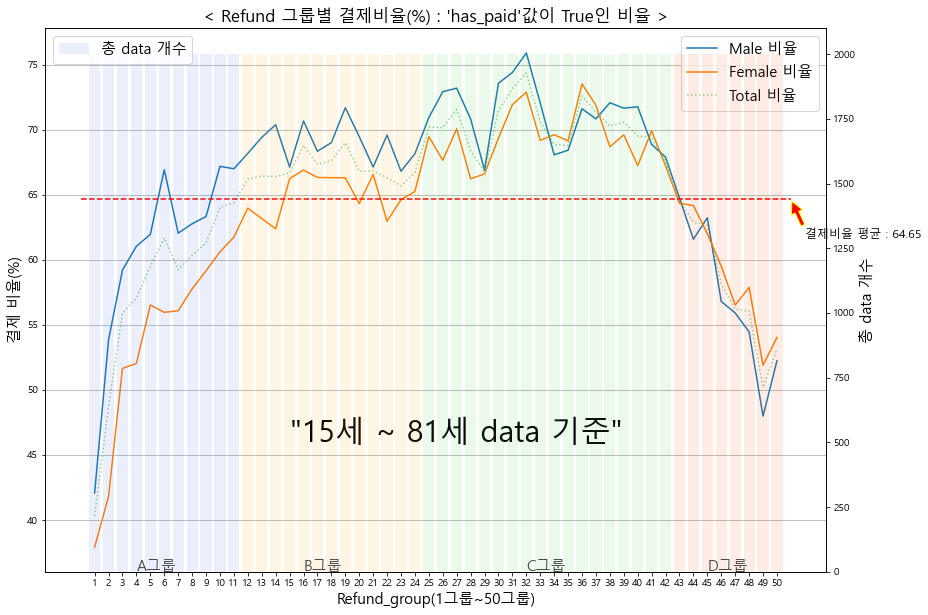

In [65]:
show_paid_rate_by_group_with_count(gender="total")

> => 앞선 분석에서 적용한 숫자그룹 및 알파벳그룹을 동일하게 적용해 그룹별 총 data 개수와 함께 표시하고, 성별/Total 결제비율 및 현재 설정된 나이대 정보를 주석으로 표시한 그래프 출력 현황을 확인함

#### 15세 ~ 19세 data 기준 종합적 비교/분석

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


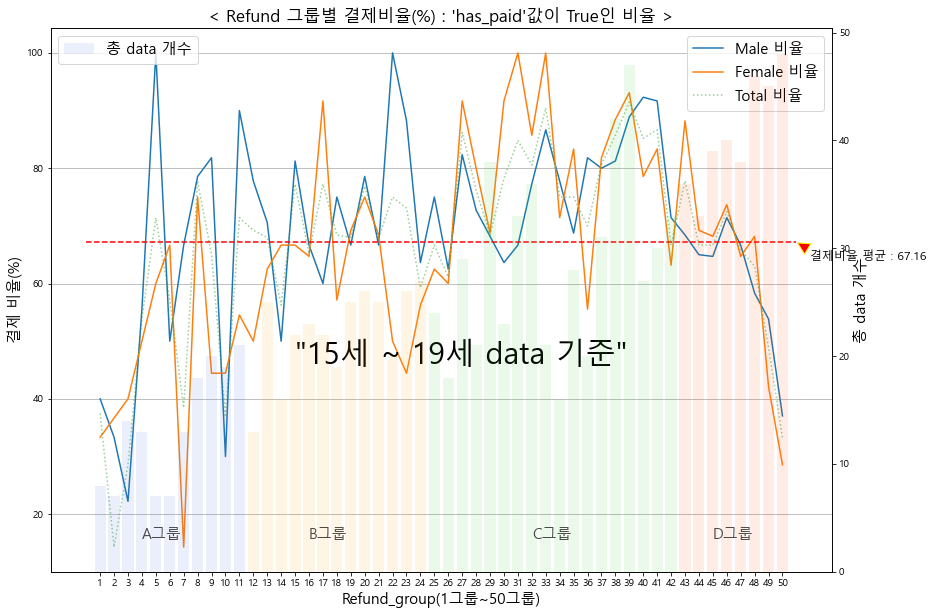

In [66]:
show_paid_rate_by_group_with_count(gender="total", age_range=(15, 19))

> => 15세\~19세의 경우, 전체적으로 data 개수가 30개 미만인 그룹이 다수 존재함에 따라 위 자료만으로 판단하기에는 한계가 존재함

> => 제한적이나마 현 data 기준으로 특성을 파악해보자면, 전체적인 추이상 하위그룹인 D그룹의 data 개수가 많고 상위그룹으로 갈수록 data 개수가 줄어드는 현상이 강하게 나타남 => 이는 나이가 어림에 따라 다른 나이대 대비 사업소득 및 기타소득의 금액이 작고, 그에 따라 refund 금액도 낮은 고객이 많다는 것을 의미함

#### 20세 ~ 24세 data 기준 종합적 비교/분석

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


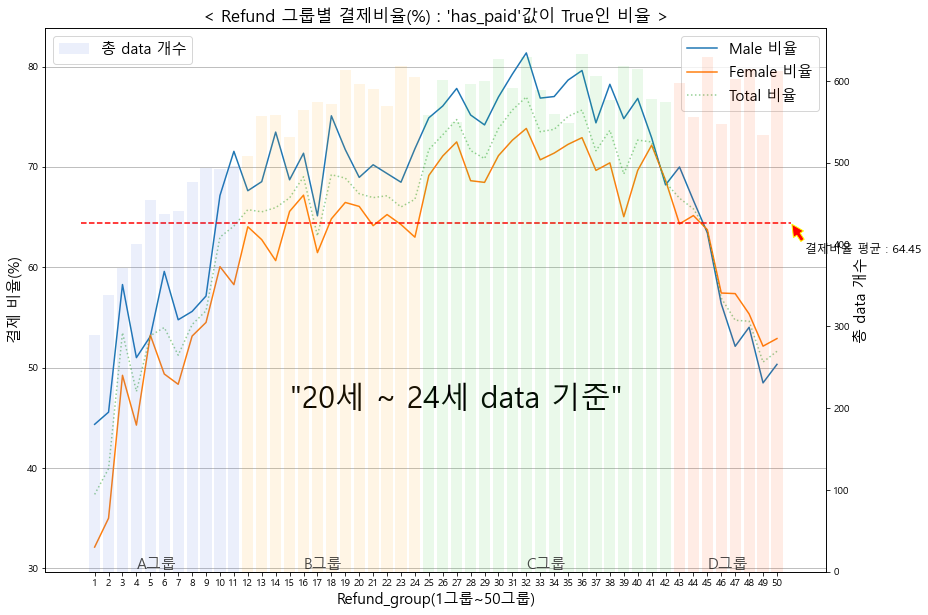

In [67]:
show_paid_rate_by_group_with_count(gender="total", age_range=(20, 24))

> => 전체 data에서 차지하는 비중이 큰 나이대인 만큼 전체 data 기준(15\~81세) 그래프와 상당히 유사한 흐름을 보이나 3가지 특징적인 부분이 관찰됨

> => 첫째, B\~D그룹은 500~600개 수준의 data 개수를 꾸준히 유지하는 데에 반해 A그룹은 최상위그룹으로 갈수록 data 개수가 급격히 줄어드는 모습을 보임 => 이는 20대 초반의 나이로 사업소득 및 기타소득의 금액이 큰 고객의 비중이 상대적으로 낮기 때문이라고 볼 수 있음

> => 둘째, 11그룹을 기점으로 A그룹으로 대변되는 상위그룹(1\~11)의 결제비율이 급격히 하락함 => 이는 앞선 분석에서 확인된 바와 같이 11그룹의 수수료 평균금액인 **1만원이 결제의 허들금액으로 작용**한 것으로 보이며("Refund 금액수준 그룹별 결제비율 분석 결과" 내용 참조), **20세\~24세 고객에게 특히 허들금액의 영향이 크게 나타난 것**이라고 볼 수 있음

> => 셋째, C그룹 남성의 결제비율이 두드러지게 높게 나타남<br/> => data 개수가 충분히 확보되지 않은 10대와 50대 이상의 고객을 제외하면 결제비율이 80%를 넘는 구간이 존재하는 유일한 나이대임 => 이는 **20대초반의 남성 고객을 많이 확보할수록 전체 결제비율을 높일 수 있음**을 의미함

#### 25세 ~ 29세 data 기준 종합적 비교/분석

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


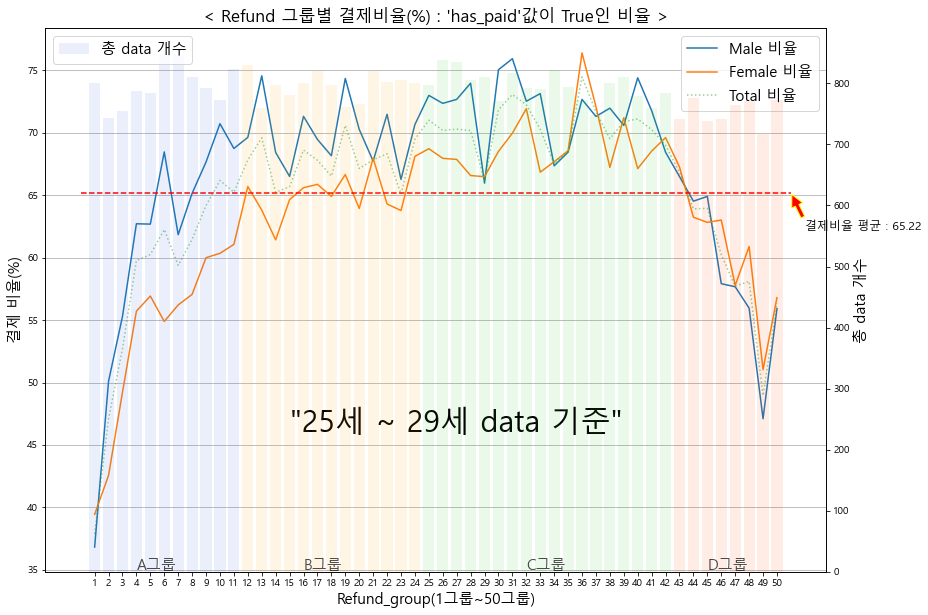

In [68]:
show_paid_rate_by_group_with_count(gender="total", age_range=(25, 29))

> => 전체 data에서 차지하는 비중이 가장 큰 나이대로, 상위그룹과 하위그룹 구분없이 전체적으로 data가 고르게 분포한다는 특징이 있음 => 20대중후반으로 경제활동을 시작하는 고객이 많아지면서 20대초반 그룹에 비해 확실히 높은 소득수준의 고객 비중이 확대된 것을 알 수 있음

> => 이용고객이 가장 많은 나이대인 만큼 결제비율 추이는 전체 data 기준(15세\~81세)과 큰 차이는 없으나, 중상위그룹(A, B그룹)에서 성별간 결제비율 차이가 비교적 크게 나타나며 특히 **B그룹 남성의 결제비율이 다른 나이대에 비해 높다는 특징**이 있음

> => 더불어, 20세\~24세 그래프와 비교해봤을 때 기울기는 상대적으로 완만해졌으나 9그룹을 기점으로 상위그룹(1\~9)의 결제비율이 급격히 하락하는 추이는 동일하게 나타남 => 20대초반과 마찬가지로 **수수료 1만원이 허들금액으로 작용**한 것으로 해석됨

#### 30세 ~ 34세 data 기준 종합적 비교/분석

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


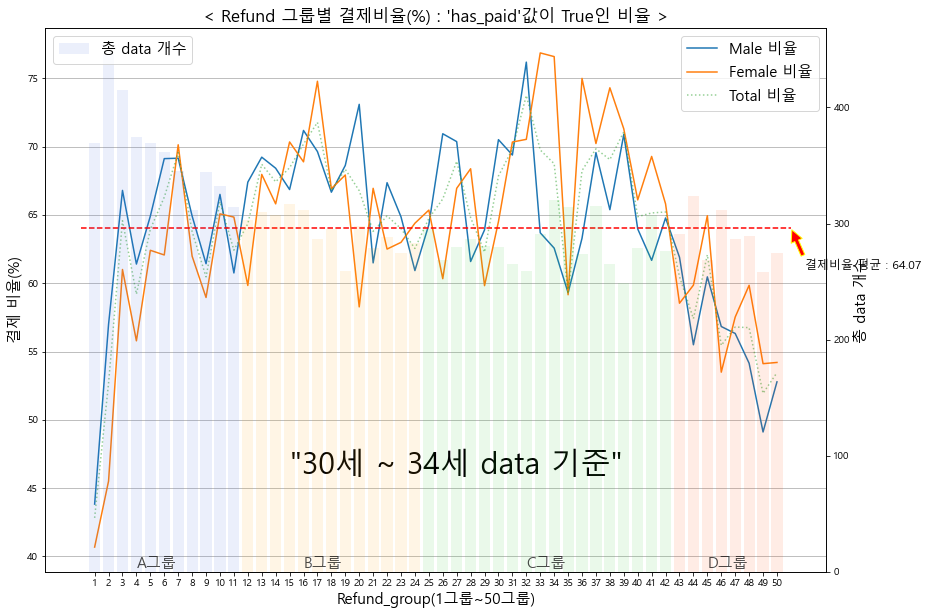

In [69]:
show_paid_rate_by_group_with_count(gender="total", age_range=(30, 34))

> => 총 data 개수의 분포가 20대와 확연히 달라진 것을 알 수 있음 => B\~D그룹의 data 개수는 250\~300개 수준을 보이는 데에 반해 상위그룹인 A그룹의 data 개수는 최상위그룹으로 갈수록 증가하는 경향을 보임<br/> => 이는 경제활동을 본격적으로 시작하는 30대초반의 특성이 반영된 것으로, 근로소득 외에 사업소득 및 기타소득의 금액수준이 매우 높은 고객들이 30대초반에 많이 분포한다는 것을 의미함

> => 뿐만 아니라, 결제비율 측면에서도 20대와는 달리 A그룹의 결제비율이 크게 낮아지지 않고 있으며 오히려 **평균 대비 높은 결제비율을 유지하는 그룹도 상당수 존재함**을 확인 가능(성별에 대한 차이도 크지 않음)<br/> => 이는 확실히 20대 대비 수수료의 허들금액이 크게 작용하지 않은 것으로 볼 수 있으며, 따라서 현재 20대 대비 현저히 적은 **30대초반의 고객을 많이 확보할수록 평균 결제금액을 높일 수 있다는 것**을 의미함

#### 35세 ~ 39세 data 기준 종합적 비교/분석

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


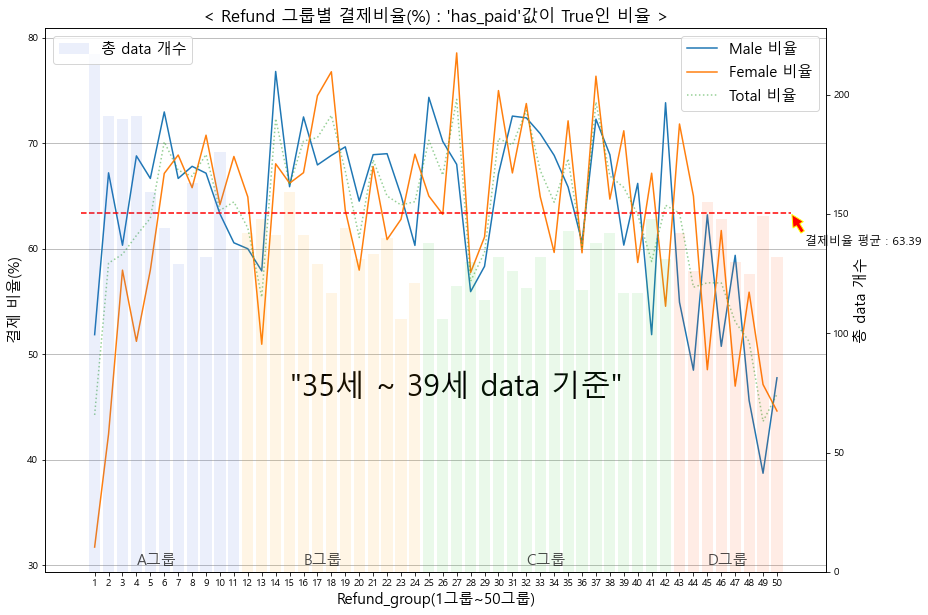

In [70]:
show_paid_rate_by_group_with_count(gender="total", age_range=(35, 39))

> => 전반적으로 30세\~34세 그래프와 비슷한 분포 및 추이를 나타내고 있으며, 상위그룹인 A그룹의 경우는 30세\~34세보다도 더 높은 결제비율을 유지하는 것으로 나타남<br/> => 이는 **평균 결제금액을 높이기 위해서는 30대 고객의 비중을 전반적으로 늘리는 것이 매우 효과적**이라는 판단을 뒷받침함

#### 40세 ~ 49세 data 기준 종합적 비교/분석

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


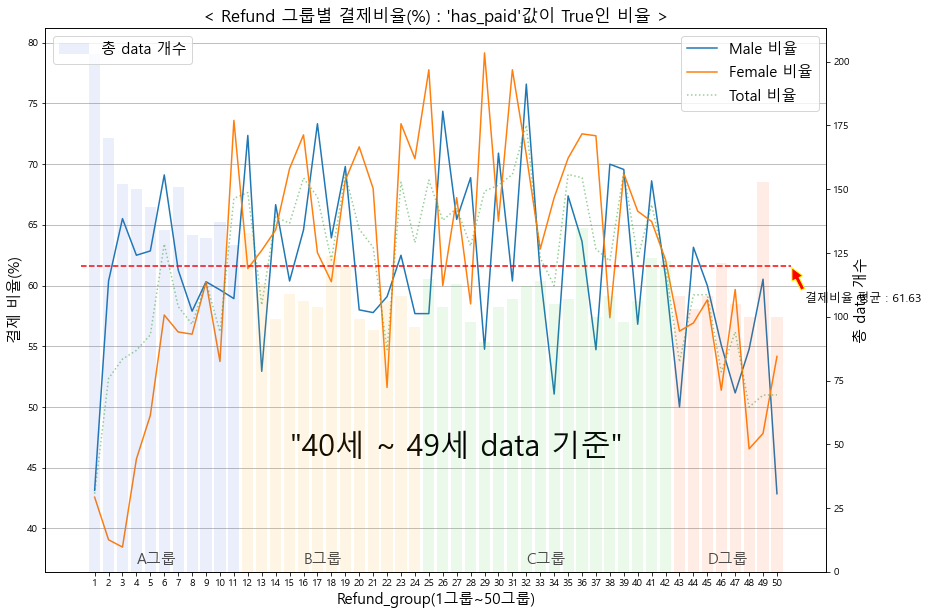

In [71]:
show_paid_rate_by_group_with_count(gender="total", age_range=(40, 49))

> => 40대의 경우 총 data 개수가 충분히 확보되지 않아 분석에 한계는 있으나, 전반적인 그룹별 data 개수의 분포는 30대후반과 비슷한 모습임

> => 결제비율 측면에서는 상위그룹의 남성 결제비율이 평균 대비 높은 수준을 유지하는 것으로 보이나, 좀 더 명확한 판단을 위해서는 추가적인 data 확보가 필요할 것으로 판단됨

#### 50세 ~ 81세 data 기준 종합적 비교/분석

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


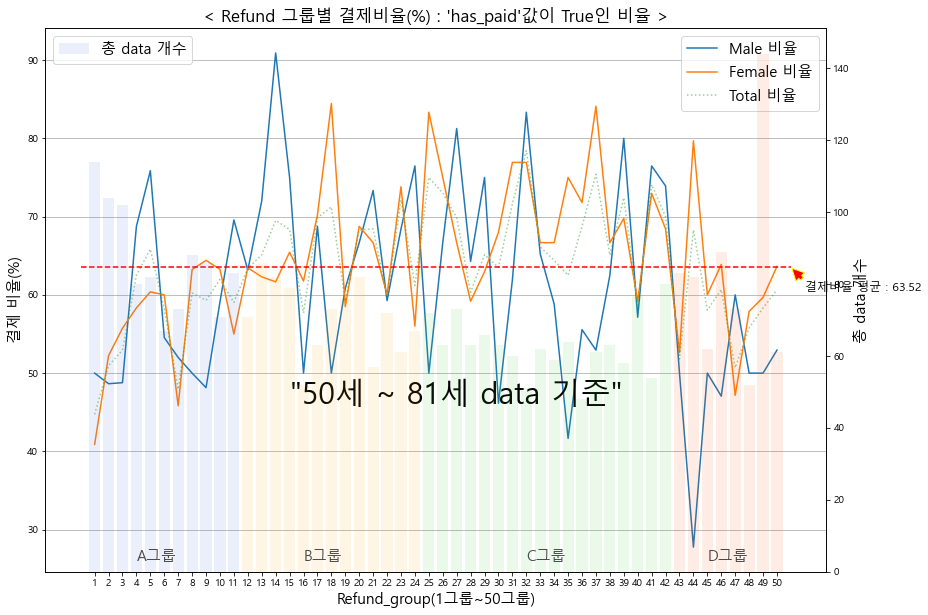

In [72]:
show_paid_rate_by_group_with_count(gender="total", age_range=(50, 81))

> 50대 이상의 data 역시 부분적으로 상위그룹 남성의 결제비율이 높은 것이 관찰되나, 명확한 판단을 위해서는 추가적인 data 확보가 필요할 것으로 판단됨

# 4. 결론

## "고객의 수수료 결제금액의 총합"을 높이기 위한 방안 - 2가지 차원의 접근

###  1) (총 결제건수를 높이는 차원) 수수료 정책상 20세\~29세 고객에게 강하게 나타나는 허들금액 효과 제거
    * 현 산출방식 기준 수수료가 1만원 이상으로 조회되는 고객이 20대일 경우, 수수료 상한선 9900원 또는 차등적 할인율 적용
    * 기대효과
      (1) 기존에 조회만 하고 수수료가 비싸 결제를 하지 않은 20대 고객의 결제 진행으로 "총 결제건수" 볼륨 증가
      (2) 기존 산출방식 대비 당장은 수수료 금액이 작아지는 측면도 있을 수 있으나 현재 data상 "has_paid"가 True인 건들의 수수료 평균이 약 6209원(첨부자료 1. 참조)인 점을 감안할 때, 9900원 수준의 결제 건 볼륨이 증가한다면 전체 평균금액도 상승하는 효과를 기대 가능
      (3) 또한, 현재 20대인 고객이 향후 30대가 되었을 때 더 큰 수수료 금액을 결제할 수 있으므로 장기적인 고객확보 차원에서도 긍정적임
      
###  2) (평균 결제금액을 높이는 차원) 현재 20대에 지나치게 치중된 고객층을 30대로 확대
    * 20대 대비 허들금액 효과가 크지 않고, 높은 수수료 금액의 비중이 큰 30대에 대한 집중 마케팅 전개
    * 기대효과
      (1) 현재 20대 대비 3분의 1수준인 30대 고객이 증가할수록 A그룹(1~11그룹)의 결제 비중이 향상될 것임(=> 평균 결제금액 증가)
        ※ A그룹의 평균 수수료는 2.3만원 수준으로, B그룹(6.4천원) 또는 C그룹(1.1천원) 대비 훨씬 높은 수준임(첨부자료 2. 참조)
      (2) 장기적인 관점에서도 30대 고객이 증가하면 연쇄적으로 소득수준이 높은 고연령층 고객의 유입이 전망되며, 이로 인해 고객 증가가 평균 결제금액 상승으로 이어지는 선순환 효과를 기대 가능

### (첨부자료 1.) 현재 data상 "has_paid"가 True인 건들의 수수료 평균 : 약 6209원

In [86]:
df_v3.query("has_paid == True")["fee"].mean()

6209.493680676949

### (첨부자료 2-1.) Refund 그룹(A~D그룹)별 수수료(fee) 금액 현황

In [84]:
df_v3.query("age >= 15 and age <= 81").groupby("refund_group_2")["fee"].describe()

,count,mean,std,min,25%,50%,75%,max
refund_group_2,,,,,,,,
A그룹,22000.0,23079.5,17007.2,8100.0,12800.0,18700.0,28500.0,307000.0
B그룹,26000.0,6446.0,2318.8,1700.0,4300.0,6000.0,8500.0,76100.0
C그룹,36000.0,1153.7,1617.4,400.0,400.0,400.0,1300.0,80800.0
D그룹,16000.0,492.7,1367.8,400.0,400.0,400.0,400.0,63800.0


### (첨부자료 2-2.) Refund 그룹(1~50그룹)별 수수료(fee) 금액 현황

In [85]:
df_v3.query("age >= 15 and age <= 81").groupby("refund_group")["fee"].describe()

,count,mean,std,min,25%,50%,75%,max
refund_group,,,,,,,,
1,2000.0,58947.9,31622.0,12800.0,42900.0,49300.0,63800.0,307000.0
2,2000.0,35433.3,5896.1,12800.0,34000.0,36100.0,38700.0,82500.0
3,2000.0,28803.2,6261.0,12800.0,28900.0,30200.0,31900.0,45500.0
4,2000.0,23773.3,6063.4,12800.0,21300.0,26400.0,27600.0,63800.0
5,2000.0,20540.5,5502.4,12800.0,12800.0,23800.0,24700.0,42500.0
6,2000.0,18642.5,4604.6,8500.0,12800.0,21300.0,22100.0,71400.0
7,2000.0,17441.0,3133.9,12800.0,12800.0,18700.0,19600.0,49700.0
8,2000.0,15132.4,3183.4,8500.0,12800.0,16200.0,17000.0,42500.0
9,2000.0,12924.5,2907.0,8500.0,8500.0,14500.0,14900.0,42500.0
